In [2]:
import os

import cartopy
import numpy as np
import pandas as pd
import shapefile
import shapely.geometry as sgeom
import xarray as xa
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib import cm, colors
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from shapely.geometry import Point, Polygon, shape

In [3]:
def check_date(date):  # date-12h
    start = date - np.timedelta64(24, "h") + np.timedelta64(30, "m")
    end = date - np.timedelta64(30, "m")
    timeframes = [start + np.timedelta64(i, "h") for i in range(24)]
    year = pd.to_datetime(start).year
    month = pd.to_datetime(start).month
    day = pd.to_datetime(start).day
    path = "mcstracking/" + str(year) + "/" + str(month).zfill(2) + "/mcstrack_" + str(year) + str(month).zfill(2) + str(day).zfill(2) + "_"
    path1 = [path + str(12 + i) + "30.nc" for i in range(12)]
    path1 = [path for path in path1 if os.path.isfile(path)]
    day = pd.to_datetime(end).day
    path = "mcstracking/" + str(year) + "/" + str(month).zfill(2) + "/mcstrack_" + str(year) + str(month).zfill(2) + str(day).zfill(2) + "_"
    path2 = [path + str(i).zfill(2) + "30.nc" for i in range(12)]
    path2 = [path for path in path2 if os.path.isfile(path)]
    data1 = xa.open_mfdataset(path1)
    data2 = xa.open_mfdataset(path2)
    data = xa.concat([data1, data2], dim="time")
    cloudtracknumber = data.cloudtracknumber
    cloudtracknumber = cloudtracknumber.compute()
    lat = cloudtracknumber.lat
    lon = cloudtracknumber.lon
    cloudtracknumber = cloudtracknumber.sum(dim="time", skipna=True)
    return cloudtracknumber, lat, lon

In [4]:
def plot_check(date, sub_id):
    cloudtracknumber, lat, lon = check_date(date)
    field = cloudtracknumber
    fig = plt.figure(figsize=(15, 7))
    vmin = np.min(field)
    vmax = np.max(field)
    norm = colors.Normalize(vmin=0, vmax=vmax)
    ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
    gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=2, color="gray", alpha=0.5, linestyle="--")
    gl.bottom_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.contourf(lon, lat, field.data, transform=cartopy.crs.PlateCarree(), norm=norm, cmap="coolwarm")
    fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-" + str(sub_id) + ".shp"
    shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
    ax.add_feature(shape_feature)
    ax.coastlines()
    divider = make_axes_locatable(ax)
    cax1 = divider.new_vertical(size="5%", pad=0.1, axes_class=plt.Axes, pack_start=True)
    fig.add_axes(cax1)
    fig.colorbar(
        cm.ScalarMappable(norm=norm, cmap="coolwarm"),
        cax=cax1,
        orientation="horizontal",
    )
    plt.show()
    return cloudtracknumber

In [5]:
def is_monsoon_precip(month):
    return (month <= 9) & (month >= 6)


data = xa.open_dataarray("/tempest/duan0000/exprecip/cpc-global/NAM_sub_precip")  # CPC
monsoon_precip = data.sel(time=(is_monsoon_precip(data.time.dt.month)))
monsoon_precip = monsoon_precip.sel(time=(monsoon_precip.time.dt.year < 2019))
del data
ext_days = {}
for sub_id in range(1, 8):
    print("sub_id: ", sub_id)
    precip = monsoon_precip.sel(sub_id=sub_id)
    precip_data = precip.data
    q1 = np.quantile(precip_data[precip_data > 1], 0.05)
    q2 = np.quantile(precip_data[precip_data > 1], 0.95)
    ext_time = precip.where(precip > q2, drop=True).time.data
    print(len(ext_time), q2)
    ext_days[sub_id] = ext_time


def start_end_time(sub_id):
    start = []
    end = []
    ext_times = ext_days[sub_id]
    length = len(ext_times)
    i = 0
    while i <= length - 1:
        j = 1
        while (j + i <= length - 1) and ((ext_times[i + j] - ext_times[i + j - 1]) / np.timedelta64(1, "D") == 1):
            j += 1
        start.append(ext_times[i] - np.timedelta64(12, "h"))
        end.append(ext_times[i + j - 1] + np.timedelta64(12, "h"))
        i += j
    return start, end

sub_id:  1
39 21.363590636973544
sub_id:  2
38 7.98353434112839
sub_id:  3
37 7.6309751208430425
sub_id:  4
77 6.2968948209451305
sub_id:  5
118 6.469523059079158
sub_id:  6
124 10.647874758983226
sub_id:  7
153 17.252742222601025


In [6]:
def MCS_precip(sub_id, field):
    fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-" + str(sub_id) + ".shp"
    shape_file = shapefile.Reader(fname)
    feature = shape_file.shapeRecords()[0]
    first = feature.shape.__geo_interface__
    polygon = shape(first)
    lon0, lat0, lon1, lat1 = polygon.bounds
    sub_field = field.sel(lat=slice(lat0, lat1), lon=slice(lon0, lon1))
    total = 0
    for i, lat in enumerate(sub_field.lat):
        for j, lon in enumerate(sub_field.lon):
            if polygon.contains(Point(lon, lat)) and sub_field[i, j] > 0:
                total += 1
    return total

In [7]:
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-" + str(5) + ".shp"
shape_file = shapefile.Reader(fname)
feature = shape_file.shapeRecords()[0]
first = feature.shape.__geo_interface__
polygon = shape(first)
polygon.bounds

(-114.0, 28.5, -105.5, 37.5)

# Sub5

In [90]:
sub_id = 5
start, end = start_end_time(sub_id)
surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surge_induced_flag.npy")
tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
features = surge_induced_flag.astype(bool) | tutt_induced_flag.astype(bool) | tc_induced_flag.astype(bool)
rest = ~features
# print(rest)
ind = np.where(rest)[0]
start_dates = np.take(start, ind)
end_dates = np.take(end, ind)
print(end_dates)

['1979-08-15T12:00:00.000000000' '1980-08-14T12:00:00.000000000'
 '1980-09-09T12:00:00.000000000' '1981-07-01T12:00:00.000000000'
 '1988-08-28T12:00:00.000000000' '1988-09-12T12:00:00.000000000'
 '1990-07-15T12:00:00.000000000' '1991-09-06T12:00:00.000000000'
 '1992-07-25T12:00:00.000000000' '1997-07-30T12:00:00.000000000'
 '1999-07-15T12:00:00.000000000' '1999-08-03T12:00:00.000000000'
 '2002-09-11T12:00:00.000000000' '2003-09-10T12:00:00.000000000'
 '2006-07-08T12:00:00.000000000' '2006-08-05T12:00:00.000000000'
 '2006-08-16T12:00:00.000000000' '2007-08-02T12:00:00.000000000'
 '2008-09-01T12:00:00.000000000' '2009-08-14T12:00:00.000000000'
 '2010-08-01T12:00:00.000000000' '2013-07-27T12:00:00.000000000'
 '2013-09-11T12:00:00.000000000' '2014-08-20T12:00:00.000000000'
 '2014-08-27T12:00:00.000000000' '2014-09-28T12:00:00.000000000'
 '2016-07-02T12:00:00.000000000' '2016-09-30T12:00:00.000000000']


2002-09-11T12:00:00.000000000


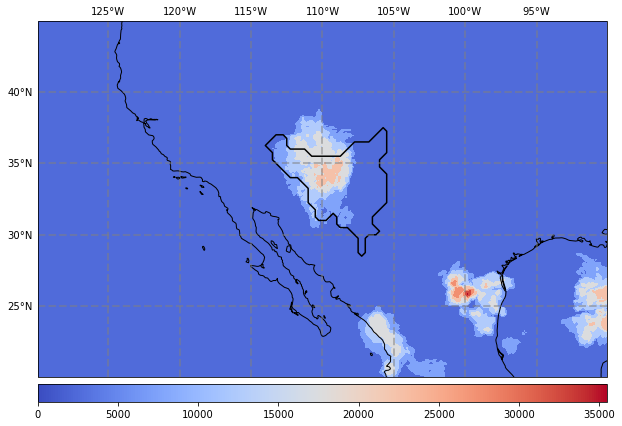

2012
2003-09-10T12:00:00.000000000


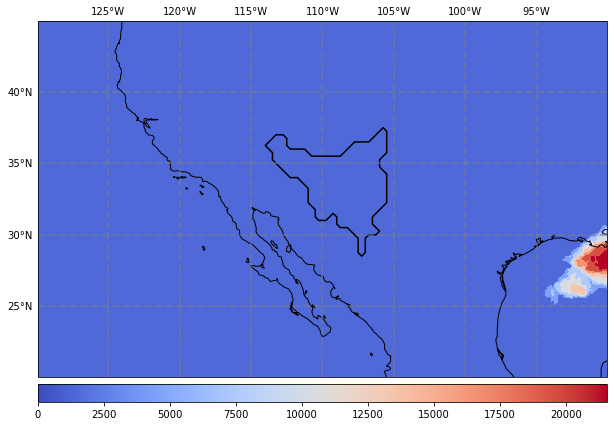

0
2006-07-08T12:00:00.000000000


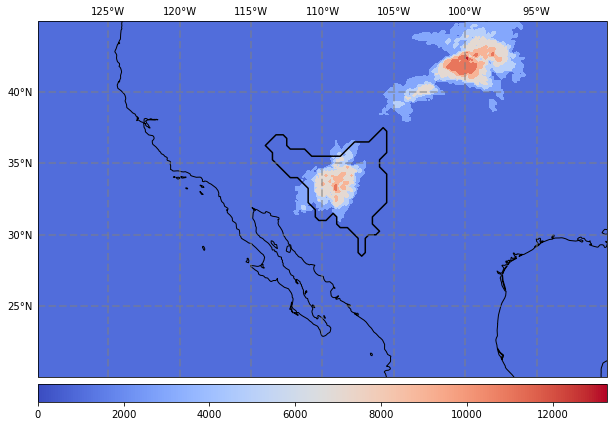

1417
2006-08-05T12:00:00.000000000


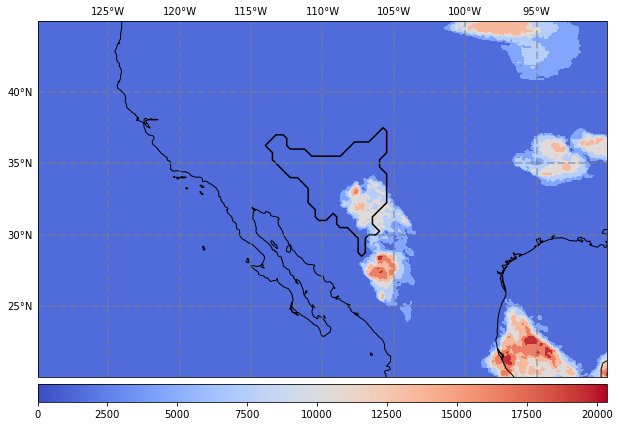

934
2006-08-16T12:00:00.000000000


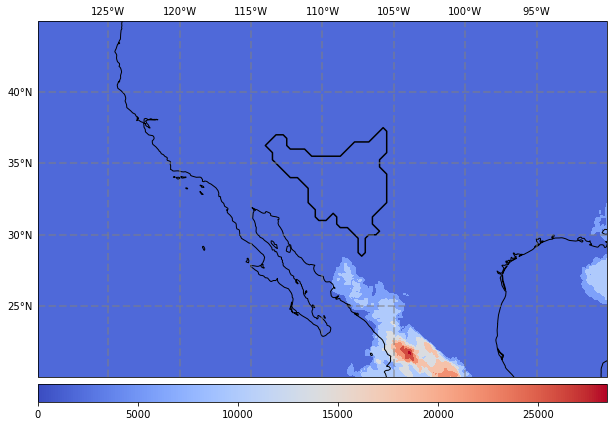

0
2007-08-02T12:00:00.000000000


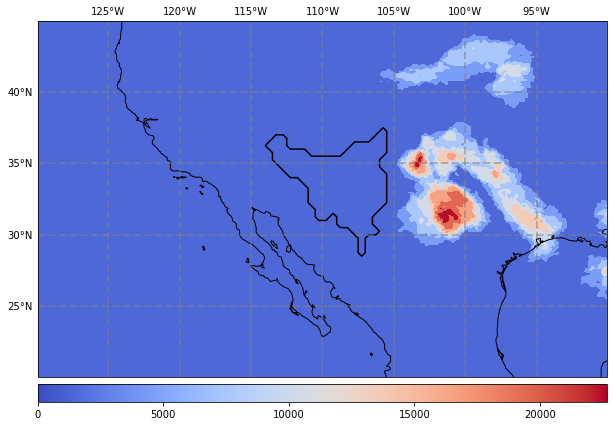

0
2008-09-01T12:00:00.000000000


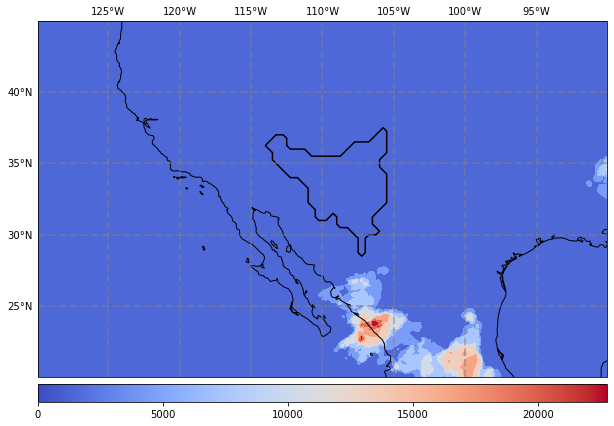

0
2009-08-14T12:00:00.000000000


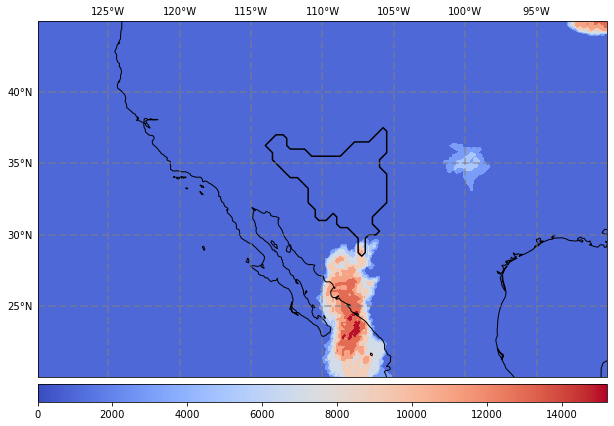

52
2010-08-01T12:00:00.000000000


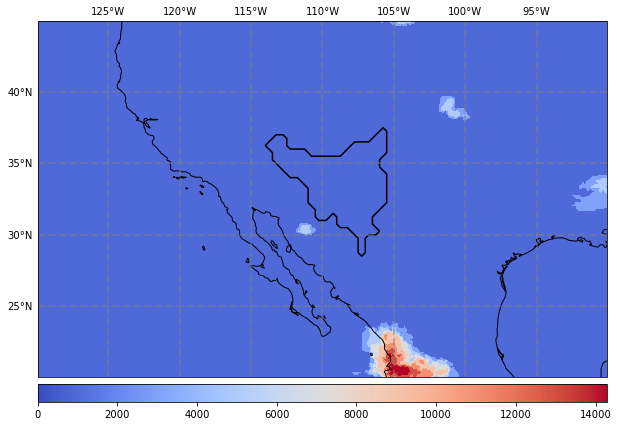

0
2013-07-27T12:00:00.000000000


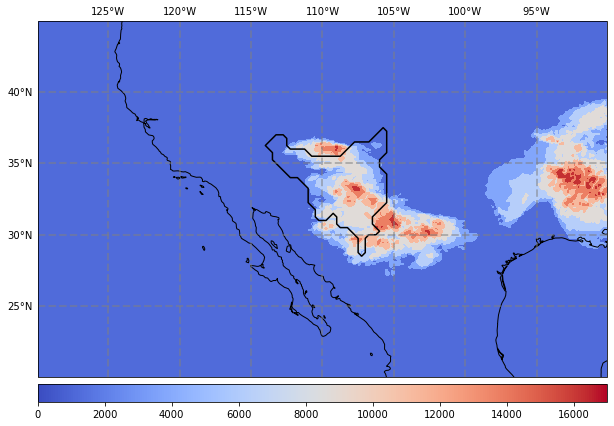

2917
2013-09-11T12:00:00.000000000


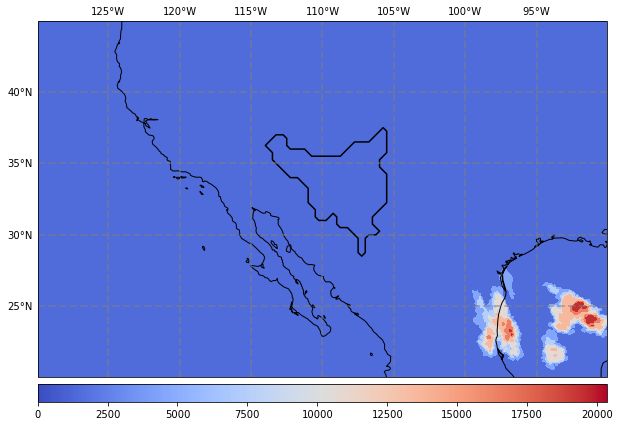

0
2014-08-20T12:00:00.000000000


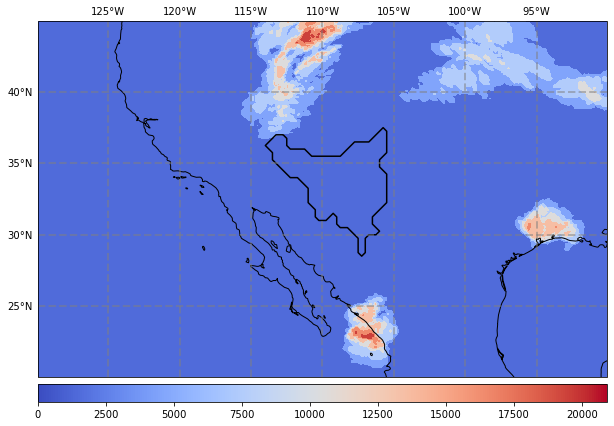

21
2014-08-27T12:00:00.000000000


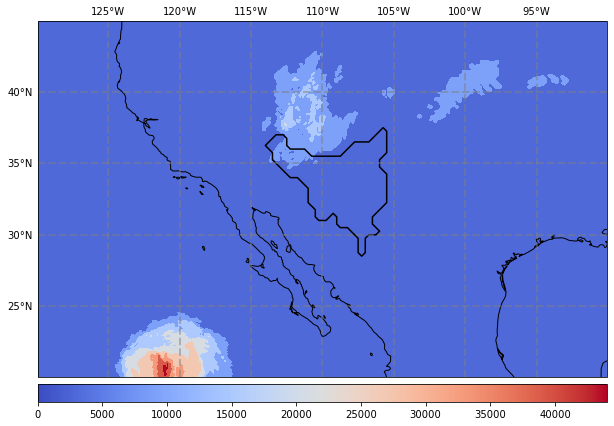

610
2014-09-28T12:00:00.000000000


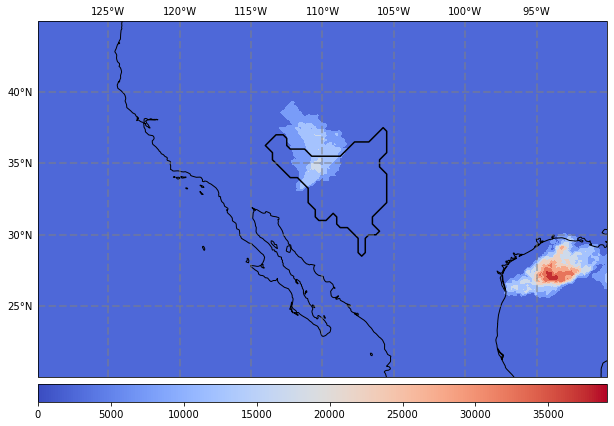

890
2016-07-02T12:00:00.000000000


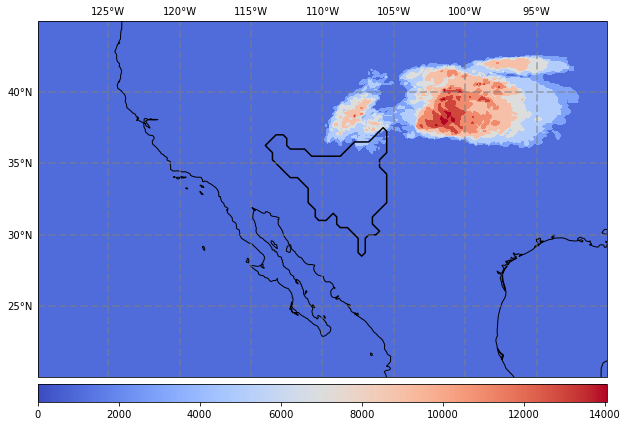

258
2016-09-30T12:00:00.000000000


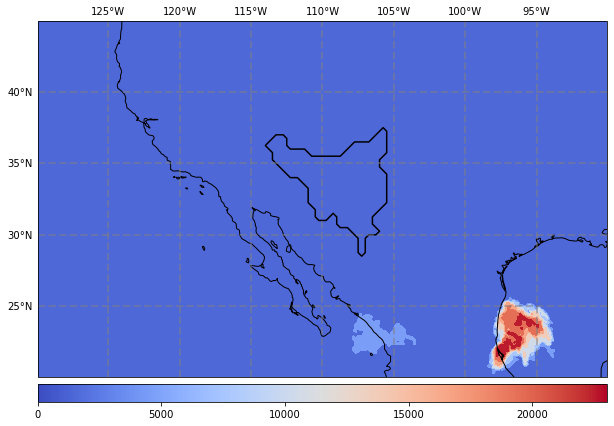

0


In [91]:
for date in end_dates:
    year = pd.to_datetime(date).year
    if year > 2000:
        print(date)
        cloudtracknumber = plot_check(date, sub_id=5)
        print(MCS_precip(sub_id, cloudtracknumber))

# Sub7

* Checked all unassigned events after 2001, and all of them are associated with MCS

In [92]:
sub_id = 7
start, end = start_end_time(sub_id)
surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surge_induced_flag.npy")
tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
features = surge_induced_flag.astype(bool) | tutt_induced_flag.astype(bool) | tc_induced_flag.astype(bool)
rest = ~features
# print(rest)
ind = np.where(rest)[0]
start_dates = np.take(start, ind)
end_dates = np.take(end, ind)
print(end_dates)

['1979-07-28T12:00:00.000000000' '1980-08-07T12:00:00.000000000'
 '1980-08-18T12:00:00.000000000' '1980-08-20T12:00:00.000000000'
 '1981-08-13T12:00:00.000000000' '1982-07-04T12:00:00.000000000'
 '1984-06-23T12:00:00.000000000' '1984-07-31T12:00:00.000000000'
 '1984-08-04T12:00:00.000000000' '1984-08-09T12:00:00.000000000'
 '1985-06-20T12:00:00.000000000' '1985-07-03T12:00:00.000000000'
 '1985-07-23T12:00:00.000000000' '1985-07-25T12:00:00.000000000'
 '1985-08-06T12:00:00.000000000' '1985-08-09T12:00:00.000000000'
 '1985-08-17T12:00:00.000000000' '1986-07-06T12:00:00.000000000'
 '1986-08-13T12:00:00.000000000' '1986-08-22T12:00:00.000000000'
 '1987-07-14T12:00:00.000000000' '1987-09-02T12:00:00.000000000'
 '1988-07-09T12:00:00.000000000' '1988-07-16T12:00:00.000000000'
 '1988-09-19T12:00:00.000000000' '1989-07-13T12:00:00.000000000'
 '1989-07-31T12:00:00.000000000' '1989-08-16T12:00:00.000000000'
 '1989-08-21T12:00:00.000000000' '1990-07-04T12:00:00.000000000'
 '1990-07-26T12:00:00.000

2001-08-29T12:00:00.000000000


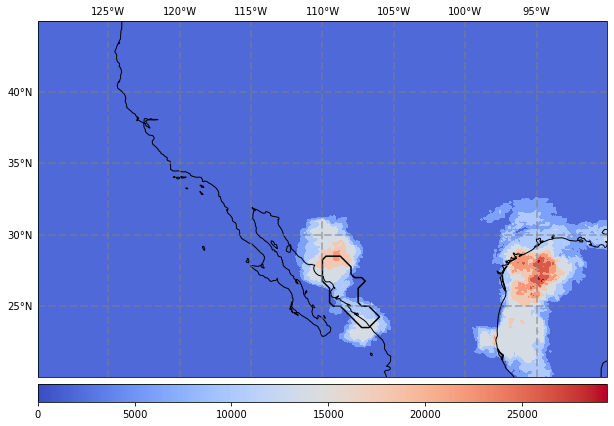

903
2002-07-20T12:00:00.000000000


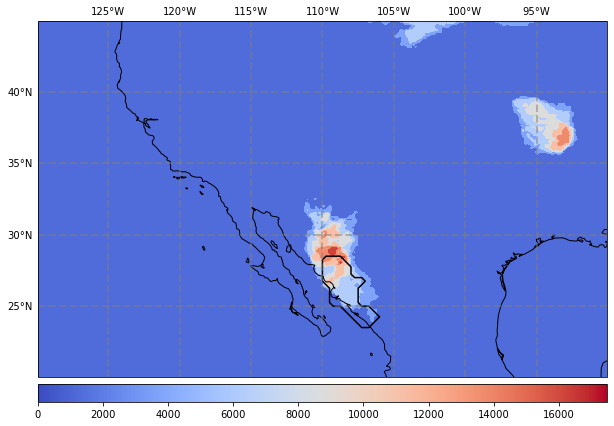

801
2005-07-27T12:00:00.000000000


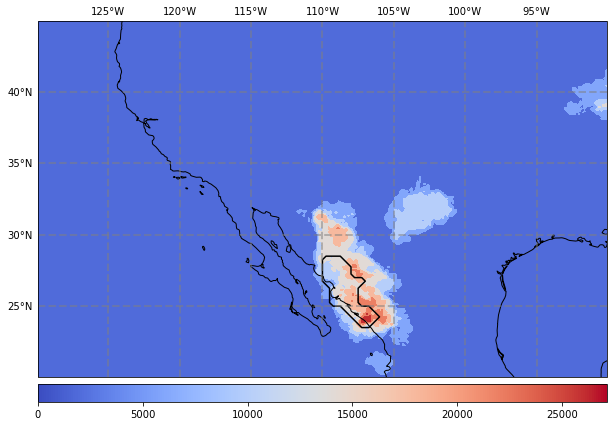

963
2006-08-07T12:00:00.000000000


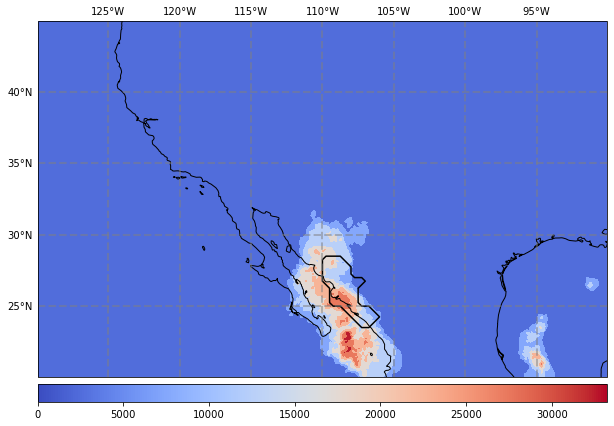

946
2006-09-06T12:00:00.000000000


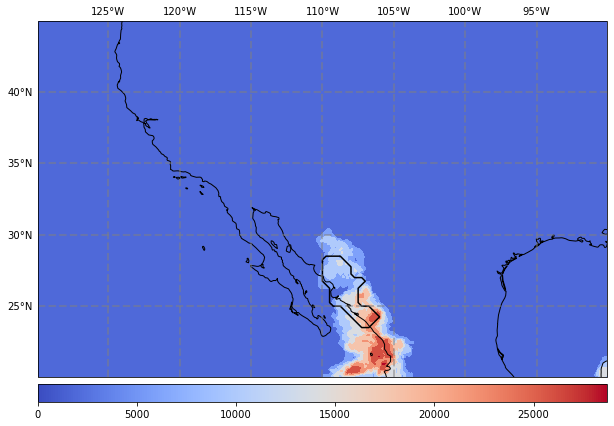

921
2008-08-21T12:00:00.000000000


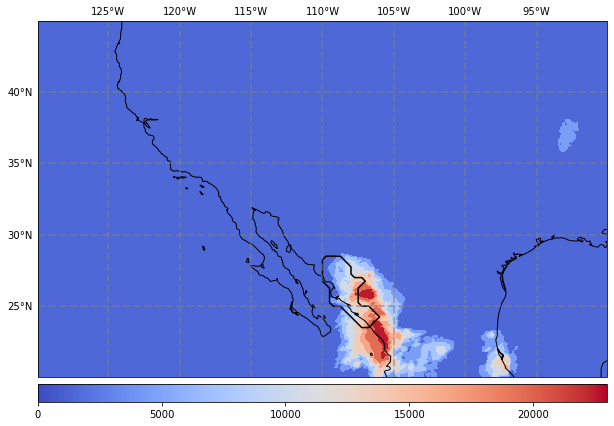

849
2009-08-24T12:00:00.000000000


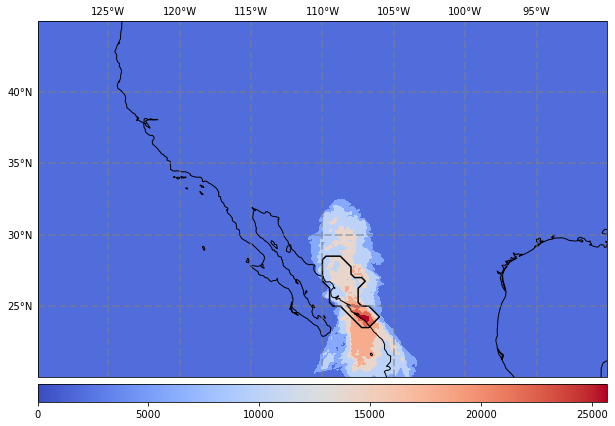

956
2010-07-30T12:00:00.000000000


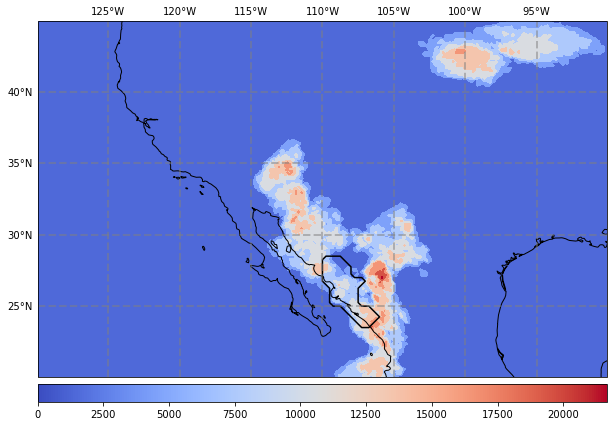

923
2011-07-21T12:00:00.000000000


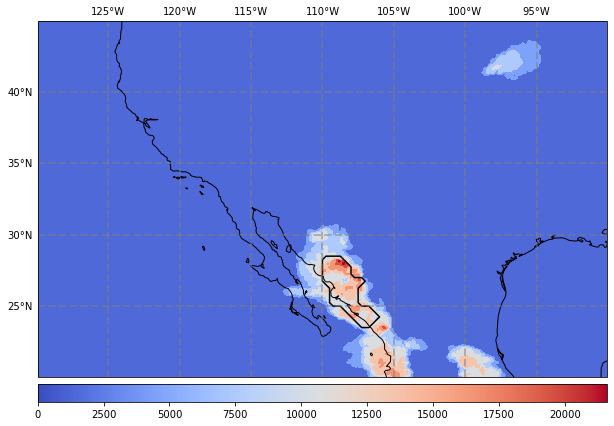

963
2011-08-15T12:00:00.000000000


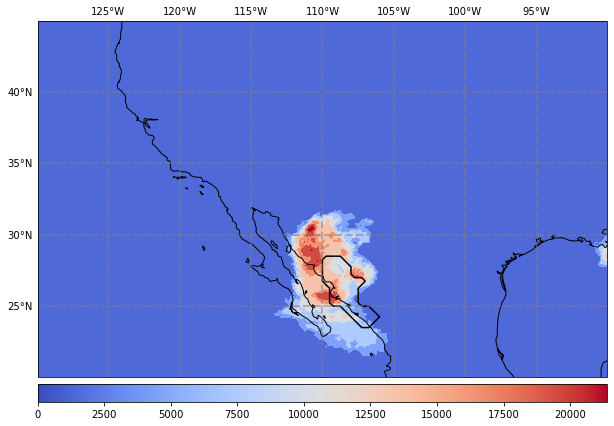

897
2012-08-20T12:00:00.000000000


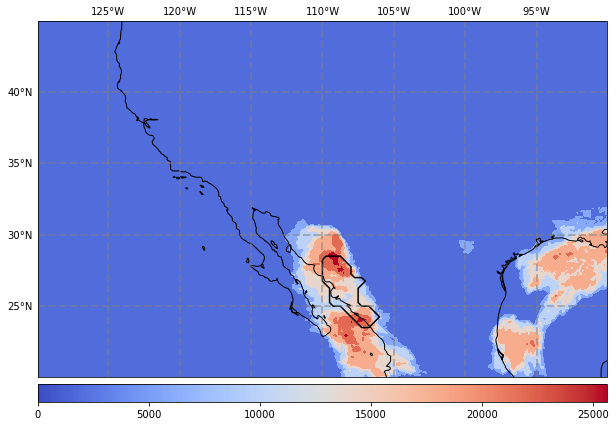

963
2014-07-09T12:00:00.000000000


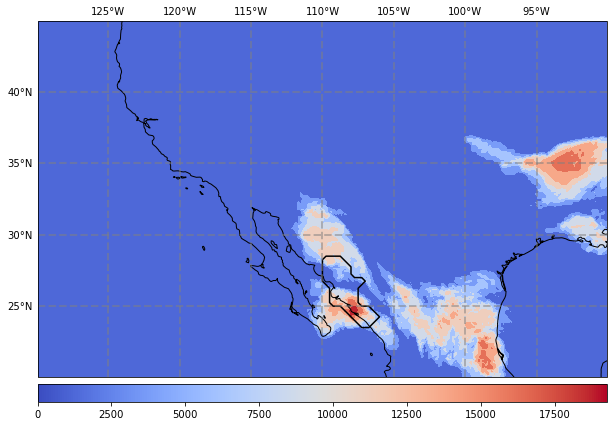

817
2014-08-14T12:00:00.000000000


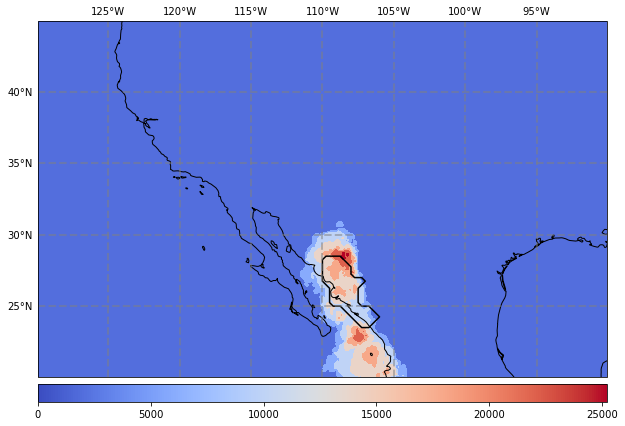

954
2014-08-18T12:00:00.000000000


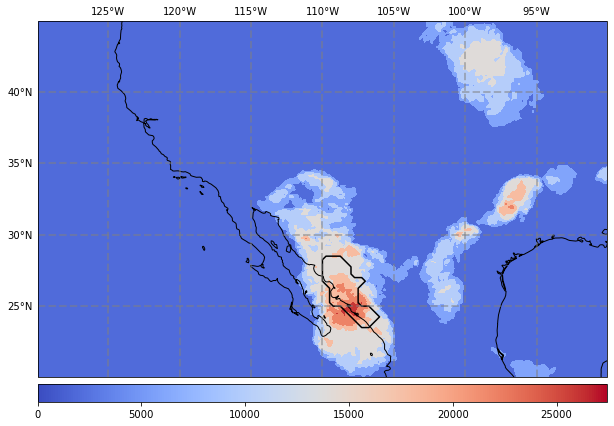

963
2015-08-17T12:00:00.000000000


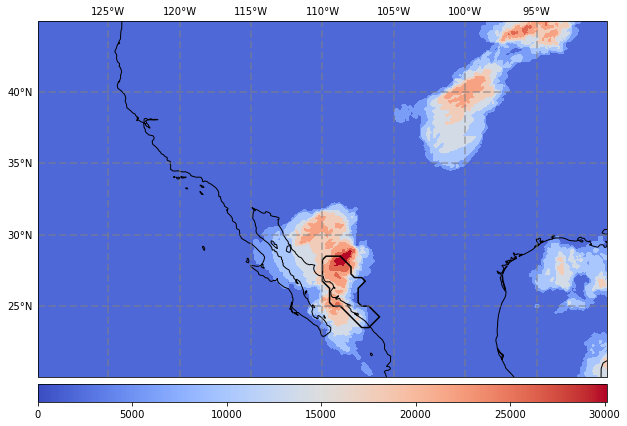

892
2016-07-28T12:00:00.000000000


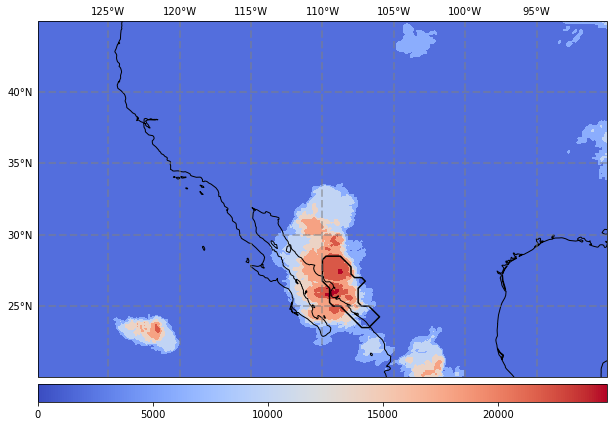

919
2016-08-19T12:00:00.000000000


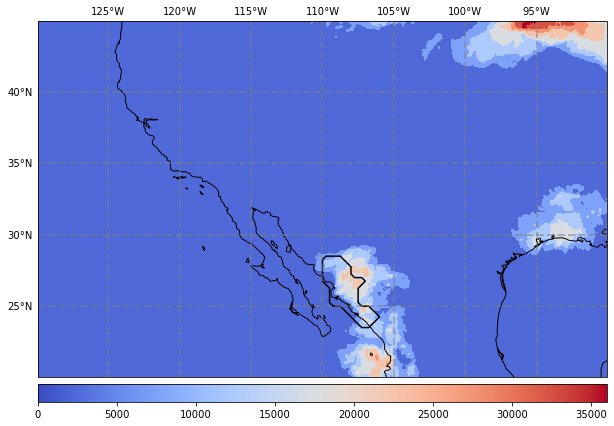

770
2017-07-27T12:00:00.000000000


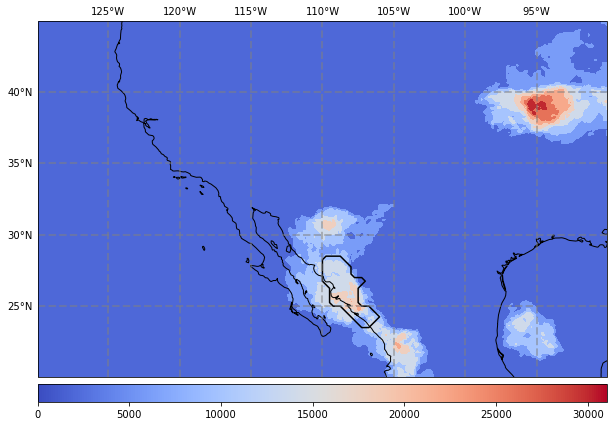

963
2018-07-17T12:00:00.000000000


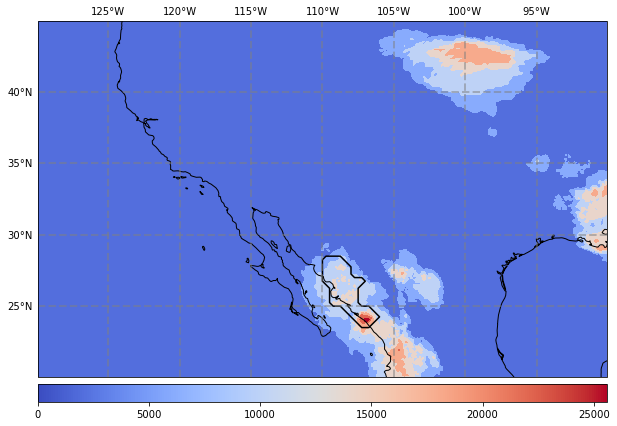

963
2018-09-08T12:00:00.000000000


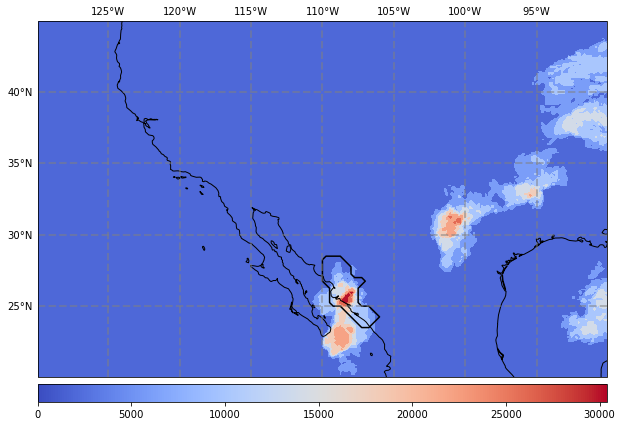

759


In [93]:
for date in end_dates:
    year = pd.to_datetime(date).year
    if year > 2000:
        print(date)
        cloudtracknumber = plot_check(date, sub_id=7)
        print(MCS_precip(sub_id, cloudtracknumber))

# Sub6

* 5 out of 16 are not associated with MCS

In [48]:
sub_id = 6
start, end = start_end_time(sub_id)
surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surge_induced_flag.npy")
tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
features = surge_induced_flag.astype(bool) | tutt_induced_flag.astype(bool) | tc_induced_flag.astype(bool)
rest = ~features
# print(rest)
ind = np.where(rest)[0]
start_dates = np.take(start, ind)
end_dates = np.take(end, ind)
print(end_dates)

['1979-07-18T12:00:00.000000000' '1979-08-08T12:00:00.000000000'
 '1981-07-24T12:00:00.000000000' '1984-08-06T12:00:00.000000000'
 '1984-08-12T12:00:00.000000000' '1985-07-31T12:00:00.000000000'
 '1986-08-15T12:00:00.000000000' '1986-09-09T12:00:00.000000000'
 '1990-07-07T12:00:00.000000000' '1990-07-16T12:00:00.000000000'
 '1990-07-18T12:00:00.000000000' '1990-07-30T12:00:00.000000000'
 '1990-08-31T12:00:00.000000000' '1991-09-10T12:00:00.000000000'
 '1996-07-13T12:00:00.000000000' '1996-07-31T12:00:00.000000000'
 '1997-08-14T12:00:00.000000000' '2004-07-24T12:00:00.000000000'
 '2005-08-09T12:00:00.000000000' '2006-07-30T12:00:00.000000000'
 '2006-09-08T12:00:00.000000000' '2007-08-05T12:00:00.000000000'
 '2009-07-03T12:00:00.000000000' '2010-08-14T12:00:00.000000000'
 '2012-07-28T12:00:00.000000000' '2012-09-05T12:00:00.000000000'
 '2014-08-15T12:00:00.000000000' '2014-08-18T12:00:00.000000000'
 '2015-07-23T12:00:00.000000000' '2015-08-17T12:00:00.000000000'
 '2015-09-04T12:00:00.000

2004-07-24T12:00:00.000000000


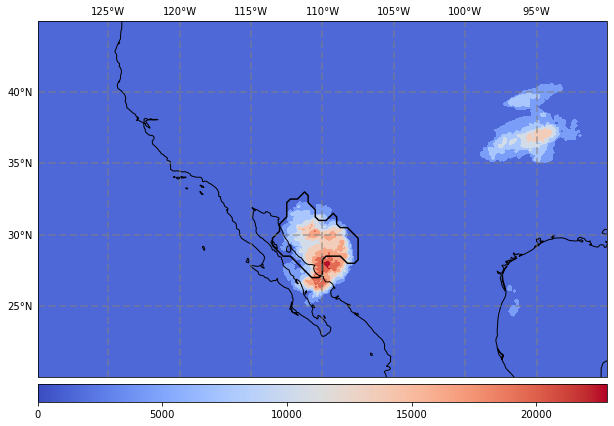

2005-08-09T12:00:00.000000000


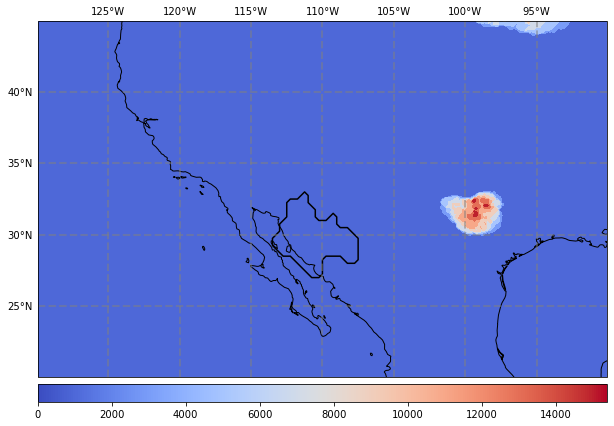

2006-07-30T12:00:00.000000000


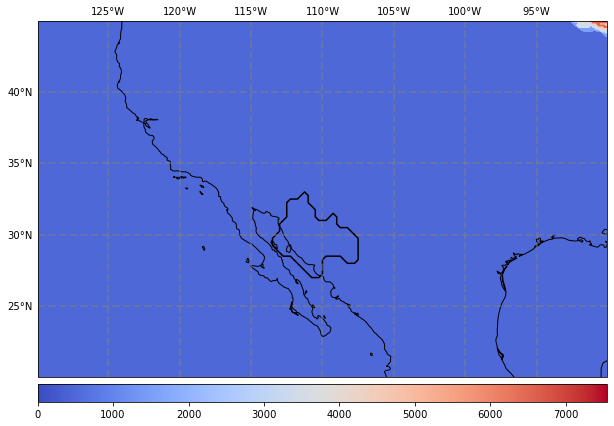

2006-09-08T12:00:00.000000000


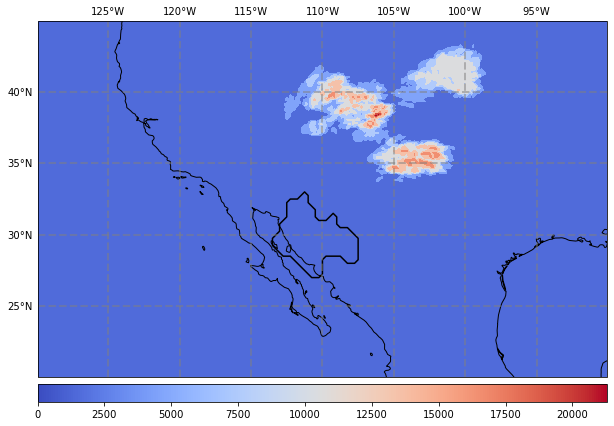

2007-08-05T12:00:00.000000000


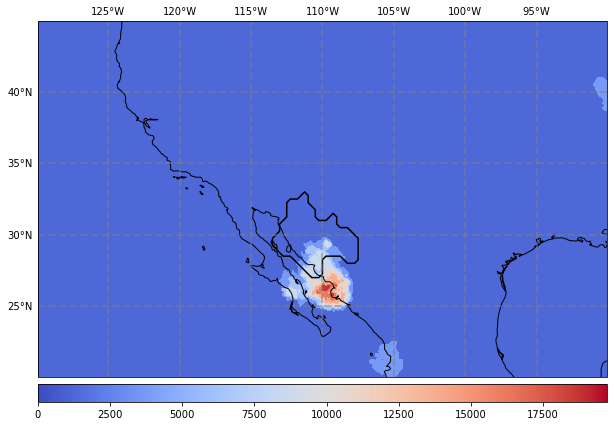

2009-07-03T12:00:00.000000000


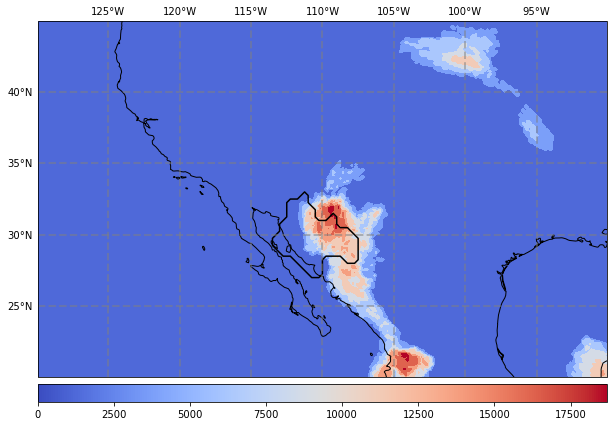

2010-08-14T12:00:00.000000000


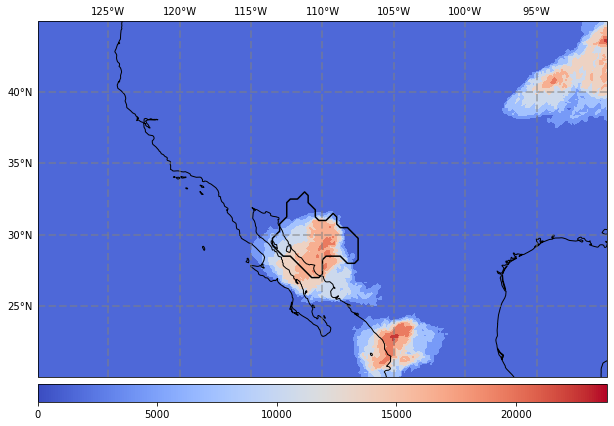

2012-07-28T12:00:00.000000000


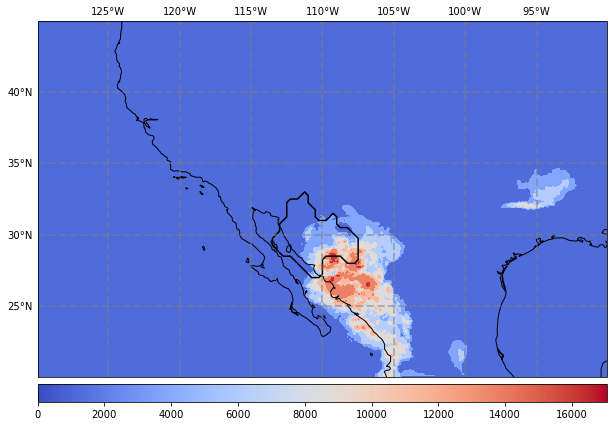

2012-09-05T12:00:00.000000000


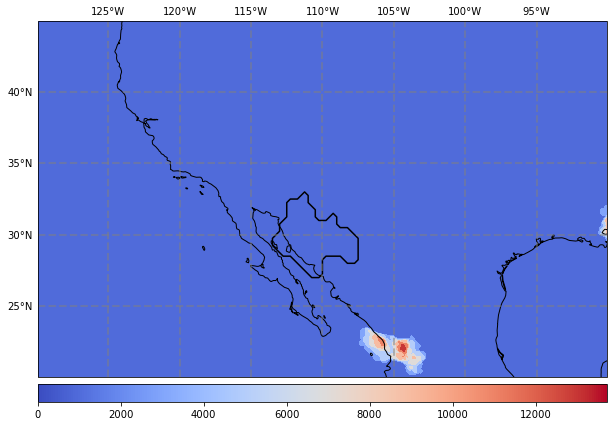

2014-08-15T12:00:00.000000000


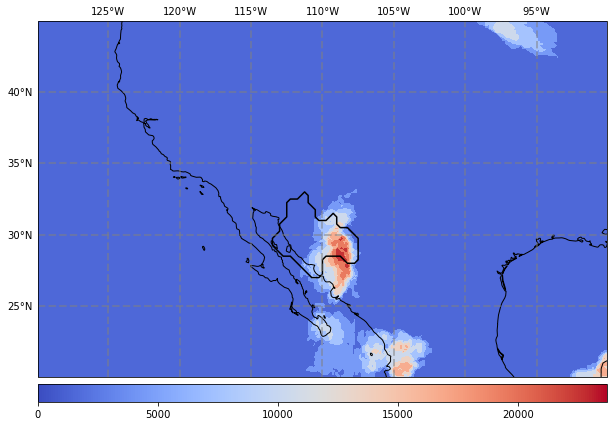

2014-08-18T12:00:00.000000000


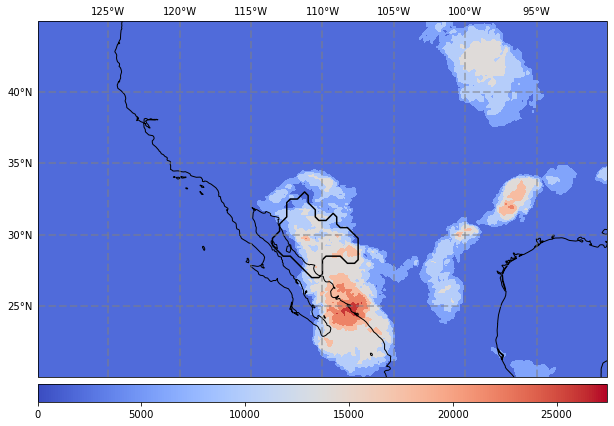

2015-07-23T12:00:00.000000000


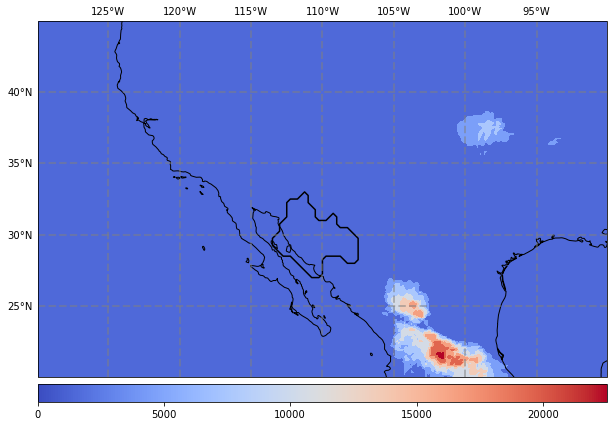

2015-08-17T12:00:00.000000000


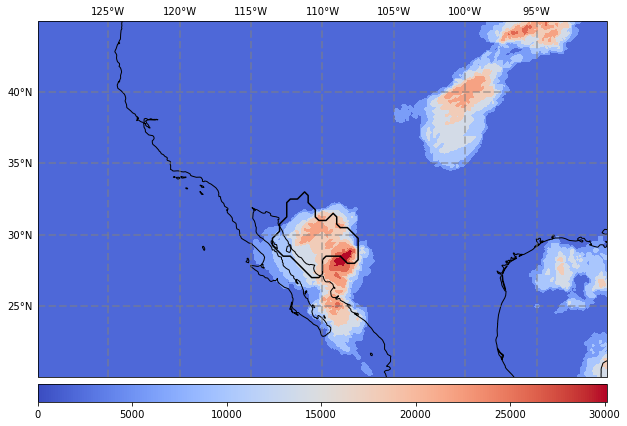

2015-09-04T12:00:00.000000000


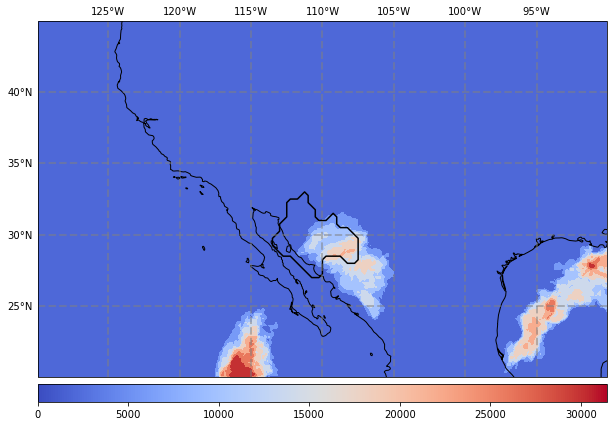

2016-07-28T12:00:00.000000000


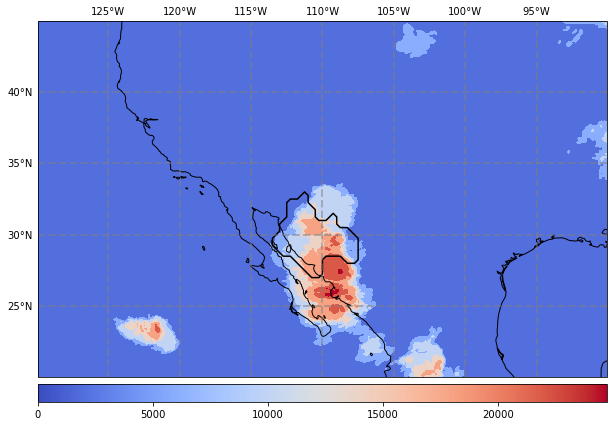

2017-07-28T12:00:00.000000000


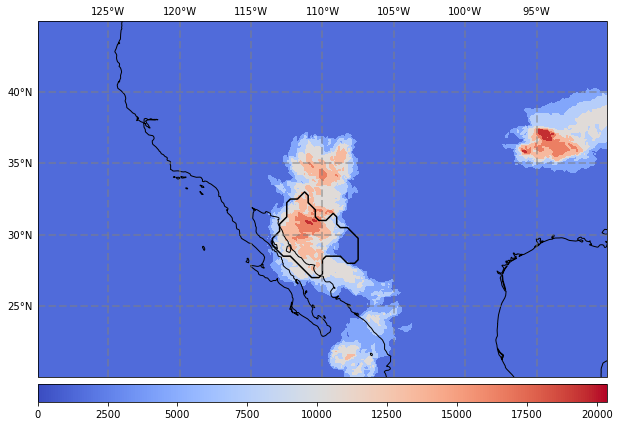

In [58]:
for date in end_dates:
    year = pd.to_datetime(date).year
    if year > 2000:
        print(date)
        plot_check(date, sub_id=6)

# Sub3

* NO

In [59]:
sub_id = 3
start, end = start_end_time(sub_id)
surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surge_induced_flag.npy")
tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
features = surge_induced_flag.astype(bool) | tutt_induced_flag.astype(bool) | tc_induced_flag.astype(bool)
rest = ~features
# print(rest)
ind = np.where(rest)[0]
start_dates = np.take(start, ind)
end_dates = np.take(end, ind)
print(end_dates)

['1980-09-07T12:00:00.000000000' '1982-09-27T12:00:00.000000000'
 '1986-09-24T12:00:00.000000000' '1990-09-23T12:00:00.000000000'
 '2000-08-30T12:00:00.000000000' '2017-07-25T12:00:00.000000000']


2017-07-25T12:00:00.000000000


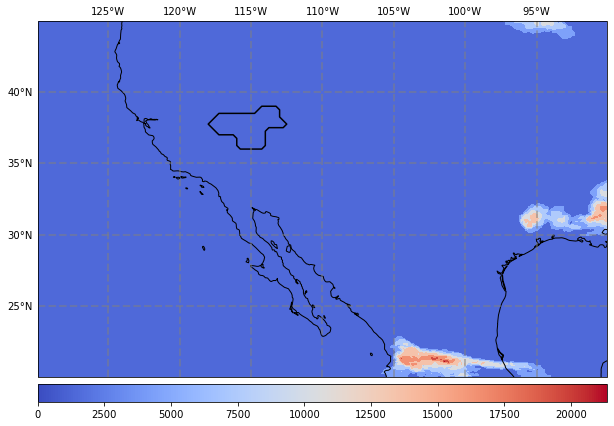

In [60]:
for date in end_dates:
    year = pd.to_datetime(date).year
    if year > 2000:
        print(date)
        plot_check(date, sub_id=3)

# Sub2

* NO

In [61]:
sub_id = 2
start, end = start_end_time(sub_id)
surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surge_induced_flag.npy")
tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
features = surge_induced_flag.astype(bool) | tutt_induced_flag.astype(bool) | tc_induced_flag.astype(bool)
rest = ~features
# print(rest)
ind = np.where(rest)[0]
start_dates = np.take(start, ind)
end_dates = np.take(end, ind)
print(end_dates)

['1979-07-20T12:00:00.000000000' '1986-07-21T12:00:00.000000000'
 '1990-09-04T12:00:00.000000000' '1997-08-05T12:00:00.000000000'
 '2000-08-30T12:00:00.000000000' '2006-09-07T12:00:00.000000000'
 '2013-09-10T12:00:00.000000000']


2006-09-07T12:00:00.000000000


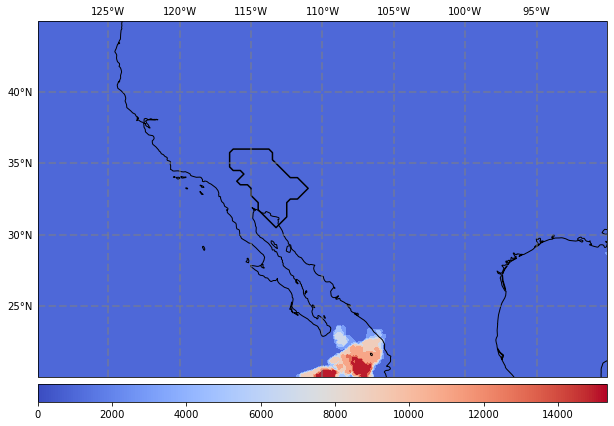

2013-09-10T12:00:00.000000000


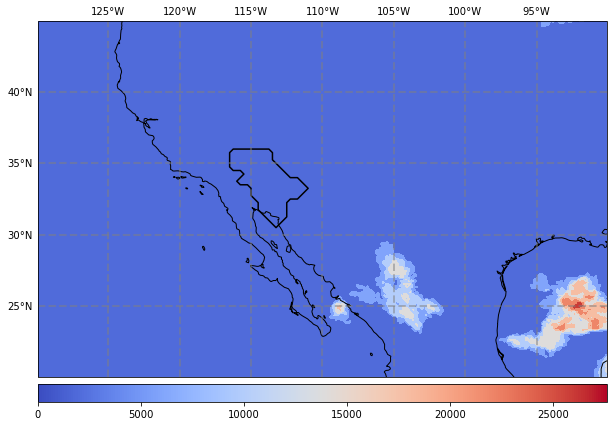

In [62]:
for date in end_dates:
    year = pd.to_datetime(date).year
    if year > 2000:
        print(date)
        plot_check(date, sub_id=2)

# Sub4

In [63]:
sub_id = 4
start, end = start_end_time(sub_id)
surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surge_induced_flag.npy")
tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
features = surge_induced_flag.astype(bool) | tutt_induced_flag.astype(bool) | tc_induced_flag.astype(bool)
rest = ~features
# print(rest)
ind = np.where(rest)[0]
start_dates = np.take(start, ind)
end_dates = np.take(end, ind)
print(end_dates)

['1982-09-27T12:00:00.000000000' '1985-07-20T12:00:00.000000000'
 '1986-09-24T12:00:00.000000000' '1988-09-12T12:00:00.000000000'
 '1991-09-07T12:00:00.000000000' '1992-07-12T12:00:00.000000000'
 '1994-09-30T12:00:00.000000000' '1997-09-16T12:00:00.000000000'
 '2002-09-11T12:00:00.000000000' '2003-09-10T12:00:00.000000000'
 '2005-08-12T12:00:00.000000000' '2008-09-01T12:00:00.000000000'
 '2010-08-02T12:00:00.000000000' '2012-09-12T12:00:00.000000000'
 '2013-07-29T12:00:00.000000000' '2013-09-11T12:00:00.000000000'
 '2013-09-23T12:00:00.000000000' '2014-08-14T12:00:00.000000000'
 '2014-09-29T12:00:00.000000000' '2015-08-03T12:00:00.000000000'
 '2015-08-08T12:00:00.000000000' '2015-08-27T12:00:00.000000000'
 '2016-08-06T12:00:00.000000000' '2017-07-26T12:00:00.000000000']


2002-09-11T12:00:00.000000000


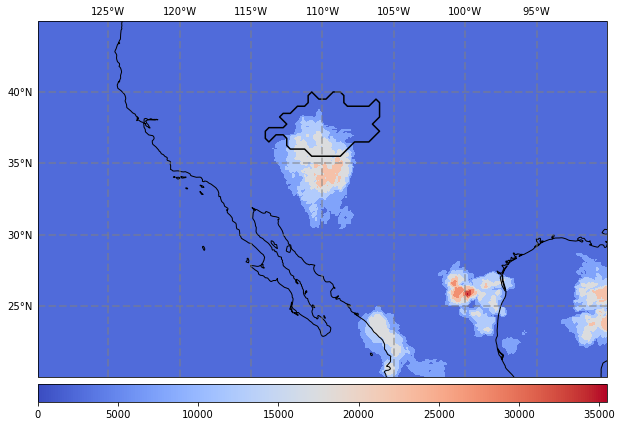

2003-09-10T12:00:00.000000000


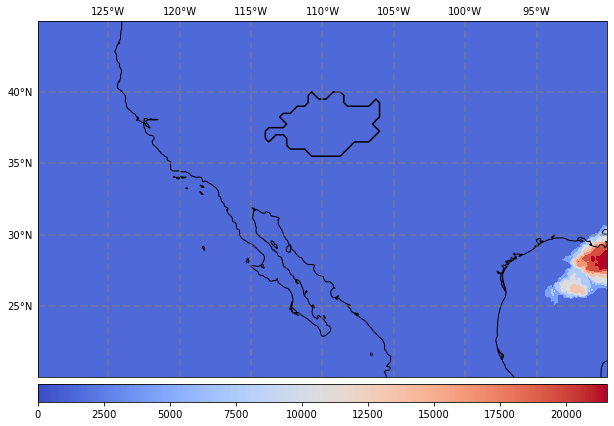

2005-08-12T12:00:00.000000000


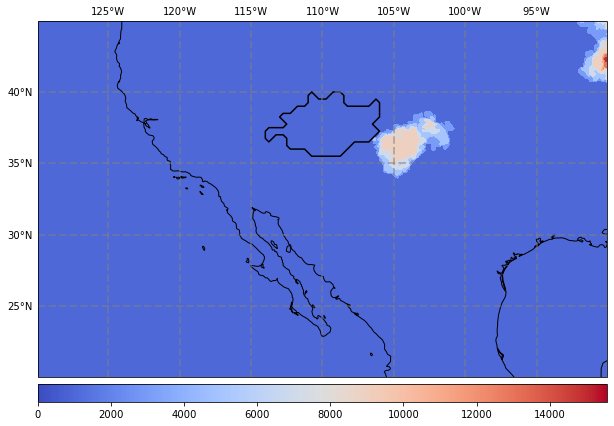

2008-09-01T12:00:00.000000000


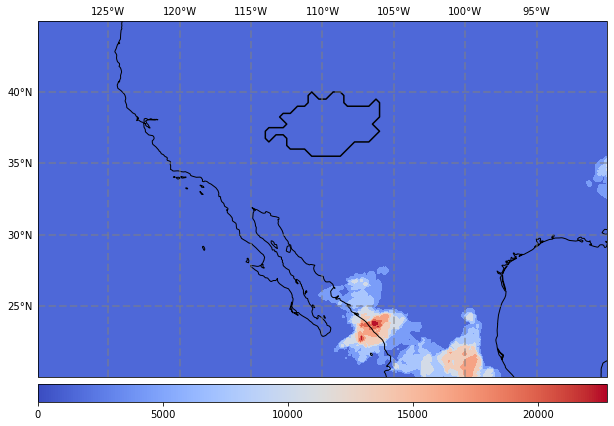

2010-08-02T12:00:00.000000000


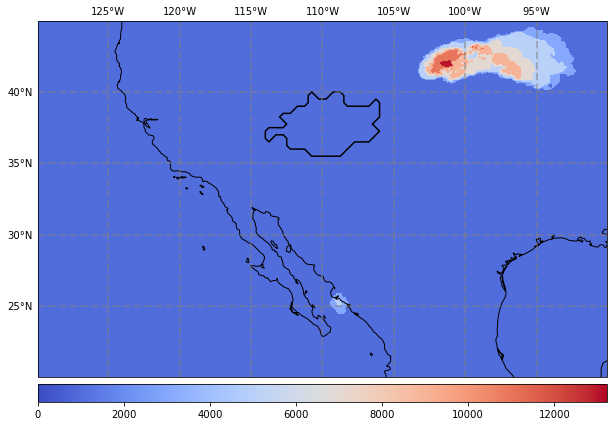

2012-09-12T12:00:00.000000000


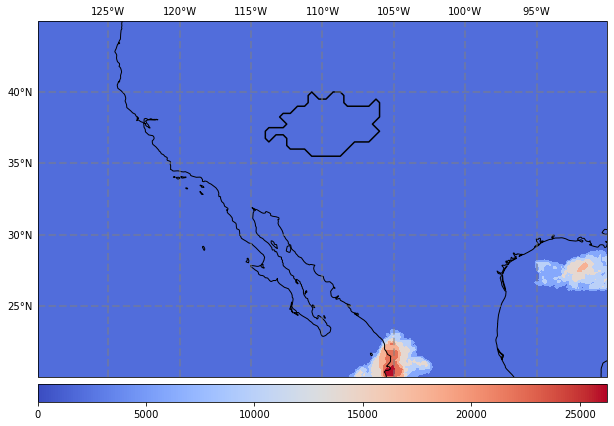

2013-07-29T12:00:00.000000000


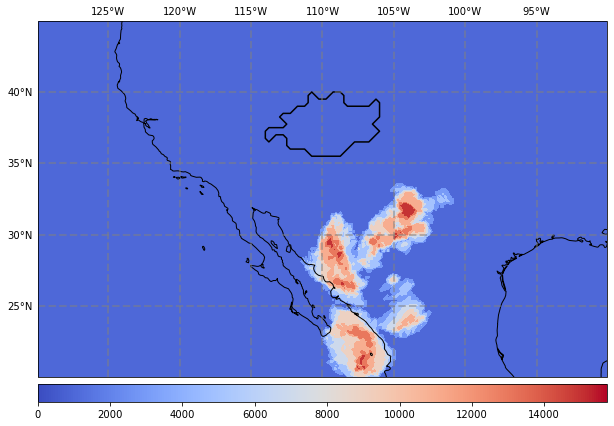

2013-09-11T12:00:00.000000000


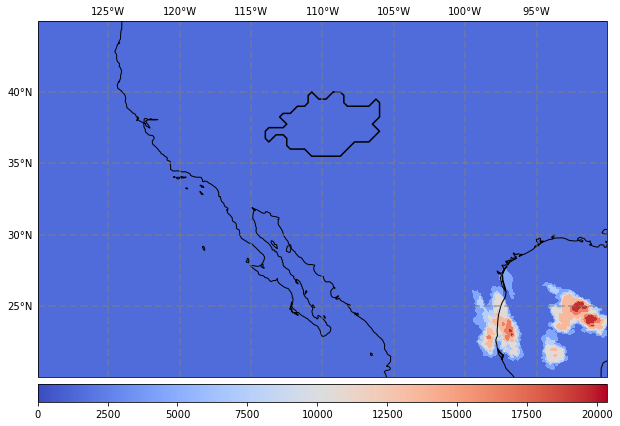

2013-09-23T12:00:00.000000000


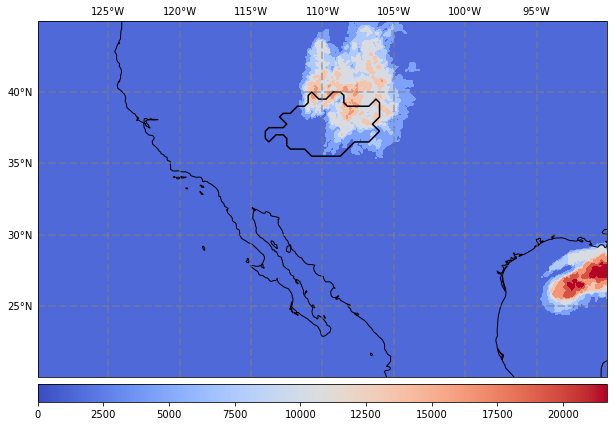

2014-08-14T12:00:00.000000000


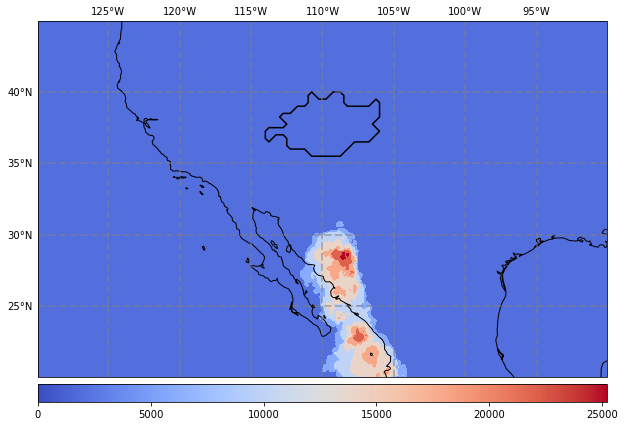

2014-09-29T12:00:00.000000000


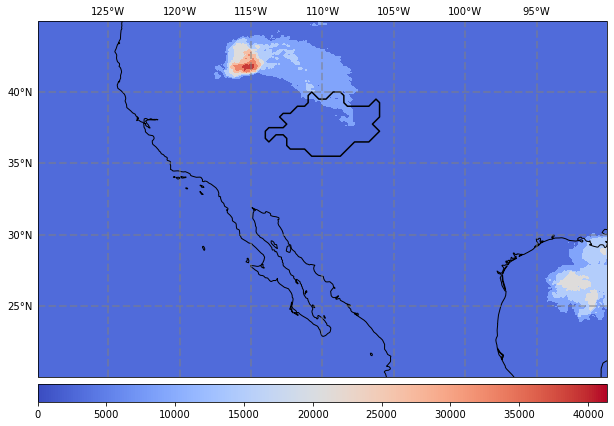

2015-08-03T12:00:00.000000000


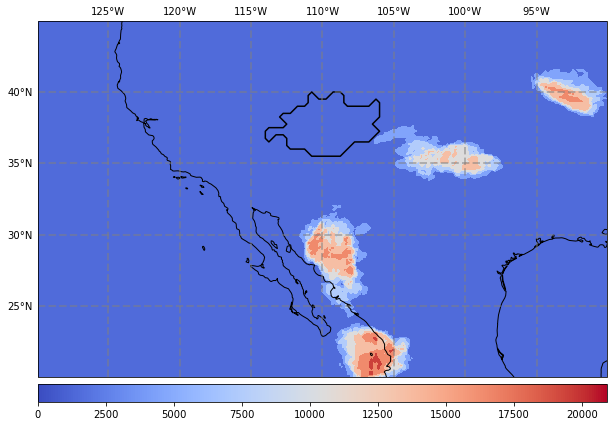

2015-08-08T12:00:00.000000000


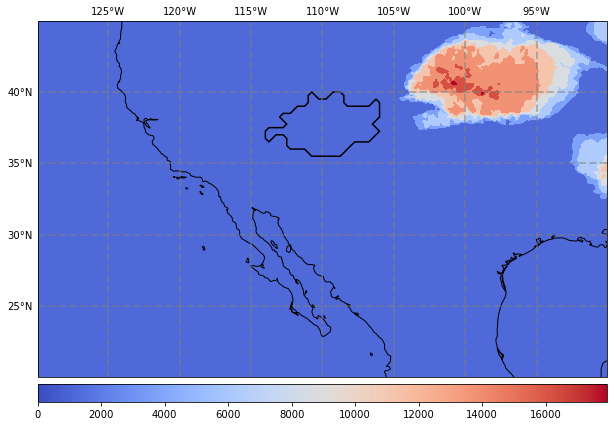

2015-08-27T12:00:00.000000000


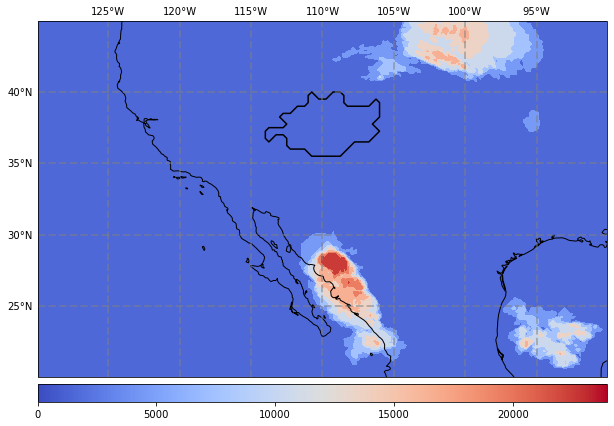

2016-08-06T12:00:00.000000000


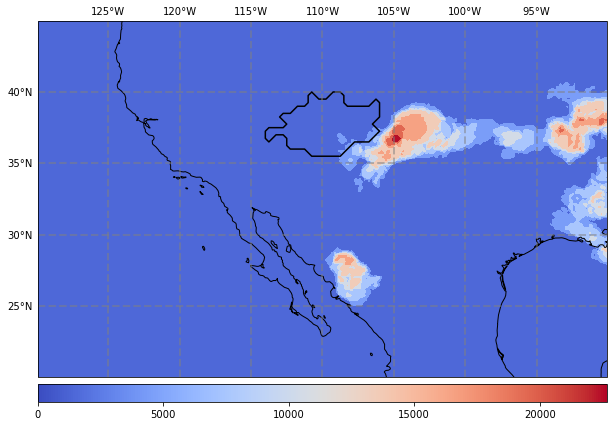

2017-07-26T12:00:00.000000000


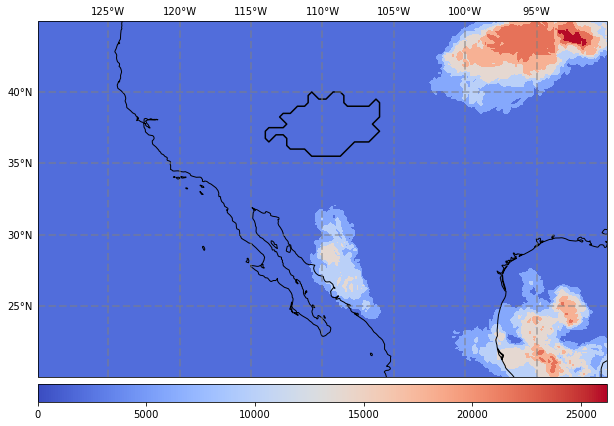

In [64]:
for date in end_dates:
    year = pd.to_datetime(date).year
    if year > 2000:
        print(date)
        plot_check(date, sub_id=4)

# Percentage

1 31
Surge:  29.0  TC:  24.0  TUTT:  1.0  MCS:  9.0
TC only:  0.0  TUTT only:  0.0  Surge only:  0.03225806451612903  MCS only:  0.0  TC_TUTT:  0.0  TC_Surge:  0.5806451612903226  Surge_TUTT:  0.03225806451612903  TC_MCS:  0.0  surge_mcs:  0.0967741935483871  tutt_mcs:  0.0 TC_SURGE_TUTT:  0.0 TC_SURGE_MCS:  0.1935483870967742 TC_TUTT_MCS:  0.0 surge_tutt_mcs:  0.0 tc_surge_tutt_mcs:  0.0
rest:  0.06451612903225812   2
2 29
Surge:  19.0  TC:  3.0  TUTT:  7.0  MCS:  3.0
TC only:  0.0  TUTT only:  0.10344827586206896  Surge only:  0.3103448275862069  MCS only:  0.0  TC_TUTT:  0.0  TC_Surge:  0.10344827586206896  Surge_TUTT:  0.13793103448275862  TC_MCS:  0.0  surge_mcs:  0.10344827586206896  tutt_mcs:  0.0 TC_SURGE_TUTT:  0.0 TC_SURGE_MCS:  0.0 TC_TUTT_MCS:  0.0 surge_tutt_mcs:  0.0 tc_surge_tutt_mcs:  0.0
rest:  0.24137931034482762   7
3 29
Surge:  21.0  TC:  1.0  TUTT:  9.0  MCS:  0.0
TC only:  0.0  TUTT only:  0.1724137931034483  Surge only:  0.4482758620689655  MCS only:  0.0  TC_TUT

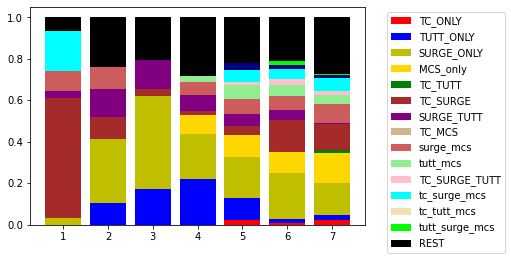

In [8]:
for i in range(1, 8):
    start, end = start_end_time(i)
    days = len(start)
    print(i, days)
    MCS_induced_flag = np.load("../ERA5/PAU/MCS_" + str(i) + ".npy")
    surge_induced_flag = np.load("../ERA5/PAU/" + str(i) + "_surge_induced_flag.npy")
    tutt_induced_flag = np.load("../ERA5/PAU/" + str(i) + "_TUTT_induced_flag.npy")
    tc_induced_flag = np.load("../ERA5/PAU/" + str(i) + "_tc_induced_flag.npy")
    MCS_induced_flag[MCS_induced_flag < 0] = 0
    print(
        "Surge: ",
        np.sum(surge_induced_flag),
        " TC: ",
        np.sum(tc_induced_flag),
        " TUTT: ",
        np.sum(tutt_induced_flag),
        " MCS: ",
        np.sum(MCS_induced_flag),
    )
    # Single one: 4
    tc_only = tc_induced_flag.astype(bool) & (~surge_induced_flag.astype(bool)) & (~tutt_induced_flag.astype(bool)) & (~MCS_induced_flag.astype(bool))
    tutt_only = (
        tutt_induced_flag.astype(bool) & (~surge_induced_flag.astype(bool)) & (~tc_induced_flag.astype(bool)) & (~MCS_induced_flag.astype(bool))
    )
    surge_only = (
        surge_induced_flag.astype(bool) & (~tc_induced_flag.astype(bool)) & (~tutt_induced_flag.astype(bool)) & (~MCS_induced_flag.astype(bool))
    )
    MCS_only = (
        MCS_induced_flag.astype(bool) & (~tc_induced_flag.astype(bool)) & (~tutt_induced_flag.astype(bool)) & (~surge_induced_flag.astype(bool))
    )
    # Double: 6
    tc_tutt = tc_induced_flag.astype(bool) & (~surge_induced_flag.astype(bool)) & (tutt_induced_flag.astype(bool)) & (~MCS_induced_flag.astype(bool))
    tc_surge = tc_induced_flag.astype(bool) & (surge_induced_flag.astype(bool)) & (~tutt_induced_flag.astype(bool)) & (~MCS_induced_flag.astype(bool))
    surge_tutt = (
        (~tc_induced_flag.astype(bool)) & (surge_induced_flag.astype(bool)) & (tutt_induced_flag.astype(bool)) & (~MCS_induced_flag.astype(bool))
    )
    tc_mcs = tc_induced_flag.astype(bool) & (~surge_induced_flag.astype(bool)) & (~tutt_induced_flag.astype(bool)) & (MCS_induced_flag.astype(bool))
    surge_mcs = (
        (~tc_induced_flag.astype(bool)) & (surge_induced_flag.astype(bool)) & (~tutt_induced_flag.astype(bool)) & (MCS_induced_flag.astype(bool))
    )
    tutt_mcs = (
        (~tc_induced_flag.astype(bool)) & (~surge_induced_flag.astype(bool)) & (tutt_induced_flag.astype(bool)) & (MCS_induced_flag.astype(bool))
    )
    # Three: 4
    tc_surge_tutt = (
        tc_induced_flag.astype(bool) & (surge_induced_flag.astype(bool)) & (tutt_induced_flag.astype(bool)) & (~MCS_induced_flag.astype(bool))
    )
    tc_surge_mcs = (
        tc_induced_flag.astype(bool) & (surge_induced_flag.astype(bool)) & (~tutt_induced_flag.astype(bool)) & (MCS_induced_flag.astype(bool))
    )
    tc_tutt_mcs = (
        tc_induced_flag.astype(bool) & (~surge_induced_flag.astype(bool)) & (tutt_induced_flag.astype(bool)) & (MCS_induced_flag.astype(bool))
    )
    tutt_surge_mcs = (
        (~tc_induced_flag.astype(bool)) & (surge_induced_flag.astype(bool)) & (tutt_induced_flag.astype(bool)) & (MCS_induced_flag.astype(bool))
    )
    # Four: 1
    tc_surge_tutt_mcs = (
        tc_induced_flag.astype(bool) & (surge_induced_flag.astype(bool)) & (tutt_induced_flag.astype(bool)) & (MCS_induced_flag.astype(bool))
    )
    # single
    plt.bar(i, np.sum(tc_only) / days, label="TC_ONLY", color="r")
    plt.bar(i, np.sum(tutt_only) / days, bottom=np.sum(tc_only) / days, label="TUTT_ONLY", color="b")
    plt.bar(i, np.sum(surge_only) / days, bottom=(np.sum(tc_only) + np.sum(tutt_only)) / days, label="SURGE_ONLY", color="y")
    plt.bar(i, np.sum(MCS_only) / days, bottom=(np.sum(tc_only) + np.sum(tutt_only) + np.sum(surge_only)) / days, label="MCS_only", color="gold")
    # two
    plt.bar(
        i,
        np.sum(tc_tutt) / days,
        bottom=(np.sum(tc_only) + np.sum(tutt_only) + np.sum(surge_only) + np.sum(MCS_only)) / days,
        label="TC_TUTT",
        color="g",
    )
    plt.bar(
        i,
        np.sum(tc_surge) / days,
        bottom=(np.sum(tc_only) + np.sum(tutt_only) + np.sum(surge_only) + np.sum(MCS_only) + np.sum(tc_tutt)) / days,
        label="TC_SURGE",
        color="brown",
    )
    plt.bar(
        i,
        np.sum(surge_tutt) / days,
        bottom=(np.sum(tc_only) + np.sum(tutt_only) + np.sum(surge_only) + np.sum(MCS_only) + np.sum(tc_tutt) + np.sum(tc_surge)) / days,
        label="SURGE_TUTT",
        color="purple",
    )
    plt.bar(
        i,
        np.sum(tc_mcs) / days,
        bottom=(np.sum(tc_only) + np.sum(tutt_only) + np.sum(surge_only) + np.sum(MCS_only) + np.sum(tc_tutt) + np.sum(tc_surge) + np.sum(surge_tutt))
        / days,
        label="TC_MCS",
        color="tan",
    )
    plt.bar(
        i,
        np.sum(surge_mcs) / days,
        bottom=(
            np.sum(tc_only)
            + np.sum(tutt_only)
            + np.sum(surge_only)
            + np.sum(MCS_only)
            + np.sum(tc_tutt)
            + np.sum(tc_surge)
            + np.sum(surge_tutt)
            + np.sum(tc_mcs)
        )
        / days,
        label="surge_mcs",
        color="indianred",
    )
    plt.bar(
        i,
        np.sum(tutt_mcs) / days,
        bottom=(
            np.sum(tc_only)
            + np.sum(tutt_only)
            + np.sum(surge_only)
            + np.sum(MCS_only)
            + np.sum(tc_tutt)
            + np.sum(tc_surge)
            + np.sum(surge_tutt)
            + np.sum(tc_mcs)
            + np.sum(surge_mcs)
        )
        / days,
        label="tutt_mcs",
        color="lightgreen",
    )
    # Three
    plt.bar(
        i,
        np.sum(tc_surge_tutt) / days,
        bottom=(
            np.sum(tc_only)
            + np.sum(tutt_only)
            + np.sum(surge_only)
            + np.sum(MCS_only)
            + np.sum(tc_tutt)
            + np.sum(tc_surge)
            + np.sum(surge_tutt)
            + np.sum(tc_mcs)
            + np.sum(surge_mcs)
            + np.sum(tutt_mcs)
        )
        / days,
        label="TC_SURGE_TUTT",
        color="pink",
    )
    plt.bar(
        i,
        np.sum(tc_surge_mcs) / days,
        bottom=(
            np.sum(tc_only)
            + np.sum(tutt_only)
            + np.sum(surge_only)
            + np.sum(MCS_only)
            + np.sum(tc_tutt)
            + np.sum(tc_surge)
            + np.sum(surge_tutt)
            + np.sum(tc_mcs)
            + np.sum(surge_mcs)
            + np.sum(tutt_mcs)
            + np.sum(tc_surge_tutt)
        )
        / days,
        label="tc_surge_mcs",
        color="aqua",
    )
    plt.bar(
        i,
        np.sum(tc_tutt_mcs) / days,
        bottom=(
            np.sum(tc_only)
            + np.sum(tutt_only)
            + np.sum(surge_only)
            + np.sum(MCS_only)
            + np.sum(tc_tutt)
            + np.sum(tc_surge)
            + np.sum(surge_tutt)
            + np.sum(tc_mcs)
            + np.sum(surge_mcs)
            + np.sum(tutt_mcs)
            + np.sum(tc_surge_tutt)
            + np.sum(tc_surge_mcs)
        )
        / days,
        label="tc_tutt_mcs",
        color="wheat",
    )
    plt.bar(
        i,
        np.sum(tutt_surge_mcs) / days,
        bottom=(
            np.sum(tc_only)
            + np.sum(tutt_only)
            + np.sum(surge_only)
            + np.sum(MCS_only)
            + np.sum(tc_tutt)
            + np.sum(tc_surge)
            + np.sum(surge_tutt)
            + np.sum(tc_mcs)
            + np.sum(surge_mcs)
            + np.sum(tutt_mcs)
            + np.sum(tc_surge_tutt)
            + np.sum(tc_surge_mcs)
            + np.sum(tc_tutt_mcs)
        )
        / days,
        label="tutt_surge_mcs",
        color="navy",
    )
    # Four
    plt.bar(
        i,
        np.sum(tc_surge_tutt_mcs) / days,
        bottom=(
            np.sum(tc_only)
            + np.sum(tutt_only)
            + np.sum(surge_only)
            + np.sum(MCS_only)
            + np.sum(tc_tutt)
            + np.sum(tc_surge)
            + np.sum(surge_tutt)
            + np.sum(tc_mcs)
            + np.sum(surge_mcs)
            + np.sum(tutt_mcs)
            + np.sum(tc_surge_tutt)
            + np.sum(tc_surge_mcs)
            + np.sum(tc_tutt_mcs)
            + np.sum(tutt_surge_mcs)
        )
        / days,
        label="tutt_surge_mcs",
        color="lime",
    )
    # Rest
    plt.bar(
        i,
        1
        - (
            np.sum(tc_only)
            + np.sum(tutt_only)
            + np.sum(surge_only)
            + np.sum(MCS_only)
            + np.sum(tc_tutt)
            + np.sum(tc_surge)
            + np.sum(surge_tutt)
            + np.sum(tc_mcs)
            + np.sum(surge_mcs)
            + np.sum(tutt_mcs)
            + np.sum(tc_surge_tutt)
            + np.sum(tc_surge_mcs)
            + np.sum(tc_tutt_mcs)
            + np.sum(tutt_surge_mcs)
            + np.sum(tc_surge_tutt_mcs)
        )
        / days,
        bottom=(
            np.sum(tc_only)
            + np.sum(tutt_only)
            + np.sum(surge_only)
            + np.sum(MCS_only)
            + np.sum(tc_tutt)
            + np.sum(tc_surge)
            + np.sum(surge_tutt)
            + np.sum(tc_mcs)
            + np.sum(surge_mcs)
            + np.sum(tutt_mcs)
            + np.sum(tc_surge_tutt)
            + np.sum(tc_surge_mcs)
            + np.sum(tc_tutt_mcs)
            + np.sum(tutt_surge_mcs)
            + np.sum(tc_surge_tutt_mcs)
        )
        / days,
        label="REST",
        color="black",
    )

    print(
        "TC only: ",
        np.sum(tc_only) / days,
        " TUTT only: ",
        np.sum(tutt_only) / days,
        " Surge only: ",
        np.sum(surge_only) / days,
        " MCS only: ",
        np.sum(MCS_only) / days,
        " TC_TUTT: ",
        np.sum(tc_tutt) / days,
        " TC_Surge: ",
        np.sum(tc_surge) / days,
        " Surge_TUTT: ",
        np.sum(surge_tutt) / days,
        " TC_MCS: ",
        np.sum(tc_mcs) / days,
        " surge_mcs: ",
        np.sum(surge_mcs) / days,
        " tutt_mcs: ",
        np.sum(tutt_mcs) / days,
        "TC_SURGE_TUTT: ",
        np.sum(tc_surge_tutt) / days,
        "TC_SURGE_MCS: ",
        np.sum(tc_surge_mcs) / days,
        "TC_TUTT_MCS: ",
        np.sum(tc_tutt_mcs) / days,
        "surge_tutt_mcs: ",
        np.sum(tutt_surge_mcs) / days,
        "tc_surge_tutt_mcs: ",
        np.sum(tc_surge_tutt_mcs) / days,
    )
    print(
        "rest: ",
        1
        - (
            np.sum(tc_only)
            + np.sum(tutt_only)
            + np.sum(surge_only)
            + np.sum(MCS_only)
            + np.sum(tc_tutt)
            + np.sum(tc_surge)
            + np.sum(surge_tutt)
            + np.sum(tc_mcs)
            + np.sum(surge_mcs)
            + np.sum(tutt_mcs)
            + np.sum(tc_surge_tutt)
            + np.sum(tc_surge_mcs)
            + np.sum(tc_tutt_mcs)
            + np.sum(tutt_surge_mcs)
            + np.sum(tc_surge_tutt_mcs)
        )
        / days,
        " ",
        days
        - (
            np.sum(tc_only)
            + np.sum(tutt_only)
            + np.sum(surge_only)
            + np.sum(MCS_only)
            + np.sum(tc_tutt)
            + np.sum(tc_surge)
            + np.sum(surge_tutt)
            + np.sum(tc_mcs)
            + np.sum(surge_mcs)
            + np.sum(tutt_mcs)
            + np.sum(tc_surge_tutt)
            + np.sum(tc_surge_mcs)
            + np.sum(tc_tutt_mcs)
            + np.sum(tutt_surge_mcs)
            + np.sum(tc_surge_tutt_mcs)
        ),
    )

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [9]:
for i in range(1, 8):
    start, end = start_end_time(i)
    days = len(start)
    print(i, days)

    surge_induced_flag = np.load("../ERA5/PAU/" + str(i) + "_surge_induced_flag.npy")
    tutt_induced_flag = np.load("../ERA5/PAU/" + str(i) + "_TUTT_induced_flag.npy")
    tc_induced_flag = np.load("../ERA5/PAU/" + str(i) + "_tc_induced_flag.npy")
    print("Surge: ", np.sum(surge_induced_flag), " TC: ", np.sum(tc_induced_flag), " TUTT: ", np.sum(tutt_induced_flag))

    tc_only = tc_induced_flag.astype(bool) & (~surge_induced_flag.astype(bool)) & (~tutt_induced_flag.astype(bool))
    tutt_only = tutt_induced_flag.astype(bool) & (~surge_induced_flag.astype(bool)) & (~tc_induced_flag.astype(bool))
    surge_only = surge_induced_flag.astype(bool) & (~tc_induced_flag.astype(bool)) & (~tutt_induced_flag.astype(bool))

    tc_tutt = tc_induced_flag.astype(bool) & (~surge_induced_flag.astype(bool)) & (tutt_induced_flag.astype(bool))
    tc_surge = tc_induced_flag.astype(bool) & (surge_induced_flag.astype(bool)) & (~tutt_induced_flag.astype(bool))
    surge_tutt = (~tc_induced_flag.astype(bool)) & (surge_induced_flag.astype(bool)) & (tutt_induced_flag.astype(bool))
    tc_surge_tutt = tc_induced_flag.astype(bool) & (surge_induced_flag.astype(bool)) & (tutt_induced_flag.astype(bool))

    print(
        "TC only: ",
        np.sum(tc_only) / days,
        " TUTT only: ",
        np.sum(tutt_only) / days,
        " Surge only: ",
        np.sum(surge_only) / days,
        " TC_TUTT: ",
        np.sum(tc_tutt) / days,
        " TC_Surge: ",
        np.sum(tc_surge) / days,
        " Surge_TUTT: ",
        np.sum(surge_tutt) / days,
        "TC_SURGE_TUTT: ",
        np.sum(tc_surge_tutt) / days,
    )
    print(
        "rest: ",
        1
        - (np.sum(tc_only) + np.sum(tutt_only) + np.sum(surge_only) + np.sum(tc_tutt) + np.sum(tc_surge) + np.sum(surge_tutt) + np.sum(tc_surge_tutt))
        / days,
        " ",
        days
        - (
            np.sum(tc_only) + np.sum(tutt_only) + np.sum(surge_only) + np.sum(tc_tutt) + np.sum(tc_surge) + np.sum(surge_tutt) + np.sum(tc_surge_tutt)
        ),
    )

1 31
Surge:  29.0  TC:  24.0  TUTT:  1.0
TC only:  0.0  TUTT only:  0.0  Surge only:  0.12903225806451613  TC_TUTT:  0.0  TC_Surge:  0.7741935483870968  Surge_TUTT:  0.03225806451612903 TC_SURGE_TUTT:  0.0
rest:  0.06451612903225812   2
2 29
Surge:  19.0  TC:  3.0  TUTT:  7.0
TC only:  0.0  TUTT only:  0.10344827586206896  Surge only:  0.41379310344827586  TC_TUTT:  0.0  TC_Surge:  0.10344827586206896  Surge_TUTT:  0.13793103448275862 TC_SURGE_TUTT:  0.0
rest:  0.24137931034482762   7
3 29
Surge:  21.0  TC:  1.0  TUTT:  9.0
TC only:  0.0  TUTT only:  0.1724137931034483  Surge only:  0.4482758620689655  TC_TUTT:  0.0  TC_Surge:  0.034482758620689655  Surge_TUTT:  0.13793103448275862 TC_SURGE_TUTT:  0.0
rest:  0.2068965517241379   6
4 64
Surge:  30.0  TC:  1.0  TUTT:  21.0
TC only:  0.0  TUTT only:  0.25  Surge only:  0.28125  TC_TUTT:  0.0  TC_Surge:  0.015625  Surge_TUTT:  0.078125 TC_SURGE_TUTT:  0.0
rest:  0.375   24
5 86
Surge:  47.0  TC:  12.0  TUTT:  24.0
TC only:  0.0232558139534

In [10]:
sub_id = 7
start, end = start_end_time(sub_id)
surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surge_induced_flag.npy")
tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
MCS_induced_flag = np.load("../ERA5/PAU/MCS_" + str(sub_id) + ".npy")
MCS_induced_flag[MCS_induced_flag < 0] = 0
features = surge_induced_flag.astype(bool) | tutt_induced_flag.astype(bool) | tc_induced_flag.astype(bool)
rest = ~features
# print(rest)
ind = np.where(rest)[0]
start_dates = np.take(start, ind)
end_dates = np.take(end, ind)
print(len(end_dates))

57


In [11]:
features = surge_induced_flag.astype(bool) | tutt_induced_flag.astype(bool) | tc_induced_flag.astype(bool) | MCS_induced_flag.astype(bool)
rest = ~features
# print(rest)
ind = np.where(rest)[0]
start_dates = np.take(start, ind)
end_dates = np.take(end, ind)
print(len(end_dates))

37


# Percipitation amount percentage

In [13]:
print(ext_days[1])

['1979-09-14T00:00:00.000000000' '1982-09-28T00:00:00.000000000'
 '1982-09-29T00:00:00.000000000' '1983-08-15T00:00:00.000000000'
 '1984-07-13T00:00:00.000000000' '1984-08-09T00:00:00.000000000'
 '1991-09-21T00:00:00.000000000' '1992-08-13T00:00:00.000000000'
 '1993-08-26T00:00:00.000000000' '1995-09-14T00:00:00.000000000'
 '1997-09-23T00:00:00.000000000' '1998-08-06T00:00:00.000000000'
 '1998-08-07T00:00:00.000000000' '1998-09-01T00:00:00.000000000'
 '2001-09-28T00:00:00.000000000' '2001-09-29T00:00:00.000000000'
 '2003-08-27T00:00:00.000000000' '2003-09-22T00:00:00.000000000'
 '2003-09-23T00:00:00.000000000' '2004-09-05T00:00:00.000000000'
 '2006-07-26T00:00:00.000000000' '2006-09-02T00:00:00.000000000'
 '2007-09-05T00:00:00.000000000' '2008-08-26T00:00:00.000000000'
 '2009-09-02T00:00:00.000000000' '2009-09-03T00:00:00.000000000'
 '2010-09-22T00:00:00.000000000' '2012-08-16T00:00:00.000000000'
 '2012-08-17T00:00:00.000000000' '2012-09-28T00:00:00.000000000'
 '2014-09-06T00:00:00.000

In [37]:
def precip_percentage(sub_id):
    surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surge_induced_flag.npy")
    tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
    tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
    MCS_induced_flag = np.load("../ERA5/PAU/MCS_" + str(sub_id) + ".npy")
    MCS_induced_flag[MCS_induced_flag < 0] = 0
    start, end = start_end_time(sub_id)
    end_0 = [time-np.timedelta64(12, 'h') for time in end]
    MCS_time = []
    tutt_time = []
    surge_time = []
    tc_time = []
    unclass_time = []
    for i in range(len(end_0)):
        if MCS_induced_flag[i]>0:
            MCS_time.append(end_0[i])
        if tutt_induced_flag[i]>0:
            tutt_time.append(end_0[i])
        if tc_induced_flag[i]>0:
            tc_time.append(end_0[i])
        if surge_induced_flag[i]>0:
            surge_time.append(end_0[i])
        if MCS_induced_flag[i]<=0 and tutt_induced_flag[i]<=0 and surge_induced_flag[i]<=0 and tc_induced_flag[i]<=0:
            unclass_time.append(end_0[i])
    
    total_precip = monsoon_precip.sel(time=end_0, sub_id=sub_id).sum().data
    if len(MCS_time)>0:
        MCS_precip = monsoon_precip.sel(time=MCS_time, sub_id=sub_id).sum().data
    else:
        MCS_precip = 0
    tutt_precip = monsoon_precip.sel(time=tutt_time, sub_id=sub_id).sum().data
    tc_precip = monsoon_precip.sel(time=tc_time, sub_id=sub_id).sum().data
    surge_precip = monsoon_precip.sel(time=surge_time, sub_id=sub_id).sum().data
    unclass_precip = monsoon_precip.sel(time=unclass_time, sub_id=sub_id).sum().data
    return total_precip, MCS_precip, tutt_precip, tc_precip, surge_precip, unclass_precip


1125.195843588339  sub_id:  1


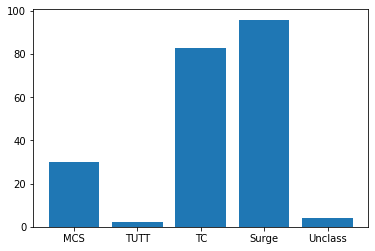

314.5949053847093  sub_id:  2


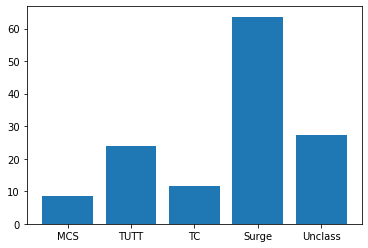

293.56555162953504  sub_id:  3


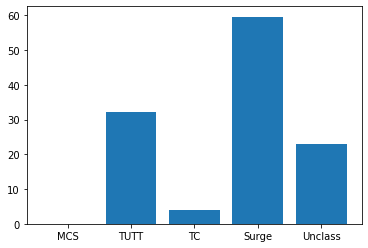

537.1352575335652  sub_id:  4


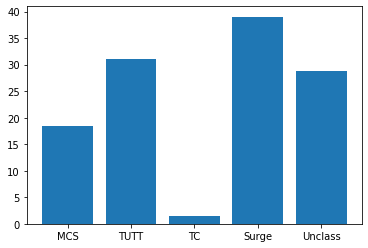

750.9040923263079  sub_id:  5


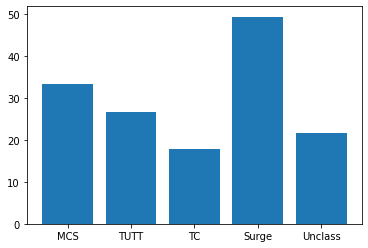

1485.752145681138  sub_id:  6


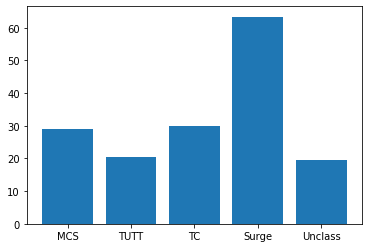

3371.5490974455784  sub_id:  7


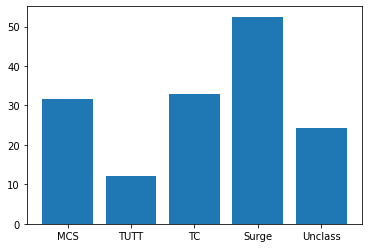

In [39]:
x = np.arange(5)
sub_id = 1
total_precip, MCS_precip, tutt_precip, tc_precip, surge_precip, unclass_precip = precip_percentage(sub_id)
print(total_precip, ' sub_id: ', sub_id)
plt.bar(x, [MCS_precip, tutt_precip, tc_precip, surge_precip, unclass_precip]/total_precip*100)
plt.xticks(x, ['MCS', 'TUTT', 'TC', 'Surge', 'Unclass'])
plt.show()
sub_id = 2
total_precip, MCS_precip, tutt_precip, tc_precip, surge_precip, unclass_precip = precip_percentage(sub_id)
print(total_precip, ' sub_id: ', sub_id)
plt.bar(x, [MCS_precip, tutt_precip, tc_precip, surge_precip, unclass_precip]/total_precip*100)
plt.xticks(x, ['MCS', 'TUTT', 'TC', 'Surge', 'Unclass'])
plt.show()
sub_id = 3
total_precip, MCS_precip, tutt_precip, tc_precip, surge_precip, unclass_precip = precip_percentage(sub_id)
print(total_precip, ' sub_id: ', sub_id)
plt.bar(x, [MCS_precip, tutt_precip, tc_precip, surge_precip, unclass_precip]/total_precip*100)
plt.xticks(x, ['MCS', 'TUTT', 'TC', 'Surge', 'Unclass'])
plt.show()
sub_id = 4
total_precip, MCS_precip, tutt_precip, tc_precip, surge_precip, unclass_precip = precip_percentage(sub_id)
print(total_precip, ' sub_id: ', sub_id)
plt.bar(x, [MCS_precip, tutt_precip, tc_precip, surge_precip, unclass_precip]/total_precip*100)
plt.xticks(x, ['MCS', 'TUTT', 'TC', 'Surge', 'Unclass'])
plt.show()
sub_id = 5
total_precip, MCS_precip, tutt_precip, tc_precip, surge_precip, unclass_precip = precip_percentage(sub_id)
print(total_precip, ' sub_id: ', sub_id)
plt.bar(x, [MCS_precip, tutt_precip, tc_precip, surge_precip, unclass_precip]/total_precip*100)
plt.xticks(x, ['MCS', 'TUTT', 'TC', 'Surge', 'Unclass'])
plt.show()
sub_id = 6
total_precip, MCS_precip, tutt_precip, tc_precip, surge_precip, unclass_precip = precip_percentage(sub_id)
print(total_precip, ' sub_id: ', sub_id)
plt.bar(x, [MCS_precip, tutt_precip, tc_precip, surge_precip, unclass_precip]/total_precip*100)
plt.xticks(x, ['MCS', 'TUTT', 'TC', 'Surge', 'Unclass'])
plt.show()
sub_id = 7
total_precip, MCS_precip, tutt_precip, tc_precip, surge_precip, unclass_precip = precip_percentage(sub_id)
print(total_precip, ' sub_id: ', sub_id)
plt.bar(x, [MCS_precip, tutt_precip, tc_precip, surge_precip, unclass_precip]/total_precip*100)
plt.xticks(x, ['MCS', 'TUTT', 'TC', 'Surge', 'Unclass'])
plt.show()